In [16]:
import json
from functools import partial
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from scipy.spatial.distance import cosine, euclidean
from scipy.spatial.distance import braycurtis, canberra, chebyshev, cityblock, correlation, cosine, euclidean, minkowski, sqeuclidean 
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split

import nltk
import string
import re
from collections import Counter
from tqdm.notebook import tqdm

import Levenshtein
import distance

import time


In [2]:
# Настройки
pd.set_option('display.max_columns', 30)

### Загружаем данные

In [3]:
PATH = "datasets/"
PATH_MODELS = "models/"
PATH_SUBMISSION = "submission/"

In [4]:
train_pairs = pd.read_parquet(PATH + "train_pairs.parquet")
train_data = pd.read_parquet(PATH + "train_data.parquet")

test_pairs = pd.read_parquet(PATH + "test_pairs_wo_target.parquet")
test_data = pd.read_parquet(PATH + "test_data.parquet")

In [5]:
test_pairs.head(2)

,variantid1,variantid2,cat3_grouped
0,52076340,290590137,Батарейки и аккумуляторы
1,64525522,204128919,"Смартфоны, планшеты, мобильные телефоны"


In [6]:
train_pairs.head(2)

,target,variantid1,variantid2
0,0.0,51197862,51198054
1,1.0,53062686,536165289


In [7]:
train_pairs["target"].value_counts()

0.0    171527
1.0    135013
Name: target, dtype: int64

In [8]:
train_data.head(2)

,variantid,name,categories,color_parsed,pic_embeddings_resnet_v1,main_pic_embeddings_resnet_v1,name_bert_64,characteristic_attributes_mapping
0,51195767,"Удлинитель Партнер-Электро ПВС 2х0,75 ГОСТ,6A,...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[оранжевый],None,"[[0.04603629, 0.18839523, -0.09973055, -0.6636...","[-0.47045058, 0.67237014, 0.48984158, -0.54485...","{""Номинальный ток, А"":[""10""],""Цвет товара"":[""о..."
1,53565809,Магнитный кабель USB 2.0 A (m) - USB Type-C (m...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Кабели ...",[красный],"[[0.26863545, -0.3130674, 0.29023397, 0.073978...","[[1.1471839, -0.665361, 0.7745614, 0.26716197,...","[-0.6575592, 0.6522429, 0.5426037, -0.54347897...","{""Конструктивные особенности"":[""Магнитная конс..."


#### Объединение аттрибутов связанных товаров

In [9]:
# # Объединаяем описания товаров в один фрейм
# Пока не делаем, потому что при сравнении описания товаров в тесте и трейне выявилось, что есть одинаковые товары, т.е. пересекаются 3021 товаров, но при попытке сравнить их по параметрам также выявилось что у некоторых товаров разные значения в параметрах, наапример товар с ИД "295040524" называется:
# - в трейне
# 'Клавиатура проводная A4Tech Fstyler FKS10, серый, белый'
# - в тесте 
# 'Клавиатура проводная A4Tech Fstyler FKS10, белый, серый'
# Надо будет разобраться какие признаки еще отличаются на сколько

attr_df = pd.concat((train_data, test_data))
attr_df.shape

(492793, 8)

In [10]:
train_features = (
    train_pairs
    .merge(
        train_data
        .add_suffix('1'),
        on="variantid1"
    )
    .merge(
        train_data
        .add_suffix('2'),
        on="variantid2"
    )
)

In [11]:
train_features.head(2)

,target,variantid1,variantid2,name1,categories1,color_parsed1,pic_embeddings_resnet_v11,main_pic_embeddings_resnet_v11,name_bert_641,characteristic_attributes_mapping1,name2,categories2,color_parsed2,pic_embeddings_resnet_v12,main_pic_embeddings_resnet_v12,name_bert_642,characteristic_attributes_mapping2
0,0.0,51197862,51198054,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",Удлинитель TDM Electric Люкс УЛ05В 1.5 м (SQ13...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.42941108, -0.5129398, -0.4753536, -0.0677...","[-0.455473, 0.58157134, 0.5870387, -0.5325003,...","{""Электробезопасность"":[""Заземление""],""Длина к..."
1,0.0,51197862,51199884,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",Удлинитель TDM Electric Люкс УЛ05В 3 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.43180764, -0.49580905, -0.5062628, -0.130...","[-0.5425725, 0.6415736, 0.51481575, -0.5687392...","{""Макс. нагрузка, Вт"":[""3500""],""Стандарт защит..."


### Features functions

##### Анализ картинок

#### Расчет расстяоний между эмбеддингами изображений и названий

In [12]:
def get_pic_features(main_pic_embeddings_1,
                     main_pic_embeddings_2,
                     percentiles: List[int], metric='euclidean'):
    """Calculate distances percentiles for 
    pairwise pic distances. Percentiles are useful 
    when product has several pictures.
    """
    
    if main_pic_embeddings_1 is not None and main_pic_embeddings_2 is not None:
        main_pic_embeddings_1 = np.array([x for x in main_pic_embeddings_1])
        main_pic_embeddings_2 = np.array([x for x in main_pic_embeddings_2])
        
        dist_m = pairwise_distances(
            main_pic_embeddings_1, main_pic_embeddings_2, metric=metric 
        )

    else:
        dist_m = np.array([[-1]])

    pair_features = []
    pair_features += np.percentile(dist_m, percentiles).tolist()

    return pair_features

def text_dense_distances(ozon_embedding, comp_embedding):
    """Calculate Euclidean and Cosine distances between
    ozon_embedding and comp_embedding.
    """
    pair_features = []
    if ozon_embedding is None or comp_embedding is None:
        pair_features = [-1, -1]
        return pair_features
    elif len(ozon_embedding) == 0 or len(comp_embedding) == 0:
        pair_features = [-1, -1]
        return pair_features

    ozon_embedding = np.array(ozon_embedding)
    comp_embedding = np.array(comp_embedding)
    if np.sum(ozon_embedding) == 0 and np.sum(comp_embedding) == 0:
        pair_features = [-1, -1]
    elif np.array_equal(ozon_embedding, comp_embedding):
        pair_features = [0, 0]
    else:
        euclidean_value = euclidean(ozon_embedding, comp_embedding)
        cosine_value = cosine(ozon_embedding, comp_embedding)
        pair_features = [euclidean_value, cosine_value]
        
    return pair_features


In [13]:
%%time
#### Сравнение текстового описания
import re
def text_title_iou(name1, name2):
    words1 = set(name1.lower().split())
    words2 = set(name2.lower().split())
    iou = len(words1 & words2)/ len(words1 | words2)
    return iou

def text_title_iou_filter(name1, name2, skip_rus=False):
    # Убираем все спецсимволы 
    name1 = re.sub('[^\w\d ]', '', name1.strip())
    name2 = re.sub('[^\w\d ]', '', name2.strip())
    if skip_rus:
        # Допускаются русские буквы только если они идут внутри слова с цифрами или символами иначе убираем их
        words1 = set(re.findall( r'(\b[^\s]*[a-zA-Z0-9][^\s]*\b)', name1.lower()))
        words2 = set(re.findall( r'(\b[^\s]*[a-zA-Z0-9][^\s]*\b)', name2.lower()))
    else:
        words1 = set(re.findall( r'([\d\w]+)', name1.lower()))
        words2 = set(re.findall( r'([\d\w]+)', name2.lower()))
    if len(words1 | words2) == 0:
        iou = 0
    else:
        iou = len(words1 & words2)/len(words1 | words2)
    return iou

train_features["iou_names"] = train_features.apply(lambda x: text_title_iou(x["name1"], x["name2"]), axis=1)
train_features["iou_names2"] = train_features.apply(lambda x: text_title_iou_filter(x["name1"], x["name2"]), axis=1)
train_features["iou_names2_eng"] = train_features.apply(lambda x: text_title_iou_filter(x["name1"], x["name2"], skip_rus=True), axis=1)

Wall time: 31 s


In [15]:
%%time
# N-gram
# Подсчитываем IoU 2-грамм и 3-грамм
spec_chars = re.escape(string.punctuation)
def calc_iou_ngram(name1, name2, n_gram, skip_rus=False):
    # Убираем все спецсимволы 
    name1 = re.sub('[^\w\d ]', '', name1.strip())
    name2 = re.sub('[^\w\d ]', '', name2.strip())
    if skip_rus:
        # Допускаются русские буквы только если они идут внутри слова с цифрами или символами иначе убираем их
        words1 = re.findall( r'(\b[^\s]*[a-zA-Z0-9][^\s]*\b)', name1)
        words2 = re.findall( r'(\b[^\s]*[a-zA-Z0-9][^\s]*\b)', name2)
        name1 = " ".join(words1)
        name2 = " ".join(words2)
        
    token_name1 = re.findall('\w+', name1.lower())
    token_name2 = re.findall('\w+', name2.lower())
    
    if len(token_name1) < n_gram or len(token_name2) < n_gram:
        return 0
    bigrams_1 = list(nltk.ngrams(token_name1, n_gram))
    bigrams_2 = list(nltk.ngrams(token_name2, n_gram))
    union = set(bigrams_1) | set(bigrams_2)
    
    intersection_1 = set(bigrams_1) & set(bigrams_2)
    reverse_bigrams_2 = set([gram[::-1] for gram in bigrams_2]) - set(bigrams_2)
    intersection_2 = set(bigrams_1) & reverse_bigrams_2
    intersection = intersection_1 | intersection_2
    iou_n_gram = len(intersection)/len(union)
    return iou_n_gram

train_features["iou_2gram_name"] = train_features.apply(lambda x: calc_iou_ngram(x["name1"], x["name2"], 2), axis=1)
train_features["iou_3gram_name"] = train_features.apply(lambda x: calc_iou_ngram(x["name1"], x["name2"], 3), axis=1)
train_features["iou_4gram_name"] = train_features.apply(lambda x: calc_iou_ngram(x["name1"], x["name2"], 4), axis=1)
train_features["iou_5gram_name"] = train_features.apply(lambda x: calc_iou_ngram(x["name1"], x["name2"], 5), axis=1)

train_features["iou_2gram_eng_name"] = train_features.apply(lambda x: calc_iou_ngram(x["name1"], x["name2"], 2, skip_rus=True), axis=1)
train_features["iou_3gram_eng_name"] = train_features.apply(lambda x: calc_iou_ngram(x["name1"], x["name2"], 3, skip_rus=True), axis=1)
train_features["iou_4gram_eng_name"] = train_features.apply(lambda x: calc_iou_ngram(x["name1"], x["name2"], 4, skip_rus=True), axis=1)
train_features["iou_5gram_eng_name"] = train_features.apply(lambda x: calc_iou_ngram(x["name1"], x["name2"], 5, skip_rus=True), axis=1)



Wall time: 2min 11s


In [17]:
%%time
# Поиск анти-слов, которые говорят, что схожие товары все-таки разные (словапристаки Pro Max Plus )
anti_words = Counter()
def find_anti_words(anti_words, name1, name2):
    words1 = set(re.findall( r'([a-z]+)', name1.lower()))
    words2 = set(re.findall( r'([a-z]+)', name2.lower()))
    xor_words = words1.symmetric_difference(words2) 
    anti_words.update(xor_words)

train_features[train_features["target"]==0][["name1", "name2"]].apply(lambda x: find_anti_words(anti_words, x["name1"], x["name2"]), axis=1)
anti_words.most_common(5)

Wall time: 4.99 s


[('pro', 10537), ('windows', 10421), ('g', 7913), ('hdd', 7671), ('x', 7616)]

In [18]:
%%time
N_TOP_ANTIWORD = 100
top_anti_words = set([w[0] for w in anti_words.most_common(N_TOP_ANTIWORD)])

def calc_anti_words_values(name1, name2):
    words1 = set(re.findall( r'([a-z]+)', name1.lower()))
    words2 = set(re.findall( r'([a-z]+)', name2.lower()))
    if len(words1 | words2) == 0:
        anti_words_val = 0
    else:
        xor_words = words1.symmetric_difference(words2)
        anti_words_val = len(xor_words & top_anti_words)/max(len(words1), len(words2))
    return anti_words_val
   
train_features["anti_words_values"] = train_features.apply(lambda x: calc_anti_words_values(x["name1"], x["name2"]), axis=1 )

Wall time: 8.05 s


##### Применение дополнительного набора сранвнеий текста

In [19]:
%%time
def calc_additional_distance(name1, name2, skip_rus=False):
    # Убираем все спецсимволы 
    name1 = re.sub('[^\w\d ]', '', name1.lower()).strip()
    name2 = re.sub('[^\w\d ]', '', name2.lower()).strip()
    if skip_rus:
        # Допускаются русские буквы только если они идут внутри слова с цифрами или символами иначе убираем их
        words1 = re.findall( r'(\b[^\s]*[a-zA-Z0-9][^\s]*\b)', name1)
        words2 = re.findall( r'(\b[^\s]*[a-zA-Z0-9][^\s]*\b)', name2)
        name1 = " ".join(words1)
        name2 = " ".join(words2)
    else:
        words1 = re.findall('\w+', name1.lower())
        words2 = re.findall('\w+', name2.lower())        
    # Значения дистанций по умолчанию (где-то схожесть, где-то расстояние
    if name1 == "" and name2 == "":
        return 1, 0, 1, 0, -0.08

    lev_ratio = Levenshtein.ratio(name1, name2)    
    lev_hamming = Levenshtein.hamming(name1, name2)/max(1, len(name1), len(name2))
    lev_seqratio = Levenshtein.seqratio(words1, words2)
    dist_sorensen = distance.sorensen(name1, name2)
    dist_fast_comp = distance.fast_comp(name1, name2)/max(1, len(name1), len(name2))
    return lev_hamming, lev_ratio, dist_sorensen, lev_seqratio, dist_fast_comp

columns_text_distance = ["lev_hamming", "lev_ratio", "dist_sorensen", "lev_seqratio", "dist_fast_comp", ]
columns_text_distance_eng = ["lev_hamming_eng", "lev_ratio_eng", "dist_sorensen_eng", "lev_seqratio_eng", "dist_fast_comp_eng", ]
train_features[columns_text_distance] = train_features.apply(lambda x: pd.Series(calc_additional_distance(x["name1"], x["name2"])), axis=1 )
train_features[columns_text_distance_eng] = train_features.apply(lambda x: pd.Series(calc_additional_distance(x["name1"], x["name2"], skip_rus=True)), axis=1 )

Wall time: 2min 44s


#### Проверка какие колонки имеют NaN

In [20]:
train_features.isna().sum()
nan_cols = [i for i in train_features.columns if train_features[i].isnull().any()]
nan_cols

['color_parsed1',
 'pic_embeddings_resnet_v11',
 'characteristic_attributes_mapping1',
 'color_parsed2',
 'pic_embeddings_resnet_v12',
 'characteristic_attributes_mapping2']

#### СХодство каритнок

In [21]:
# Для случаев когда у продукта нет дополнительных изображений, то используем основное изображение как дополнительное.
train_features["pic_embeddings_resnet_v11"] = train_features.apply(lambda x: x["main_pic_embeddings_resnet_v11"] if x["pic_embeddings_resnet_v11"] is None else x["pic_embeddings_resnet_v11"], axis=1)
train_features["pic_embeddings_resnet_v12"] = train_features.apply(lambda x: x["main_pic_embeddings_resnet_v12"] if x["pic_embeddings_resnet_v12"] is None else x["pic_embeddings_resnet_v12"], axis=1)

In [22]:
get_pic_features_func = partial(
    get_pic_features,
    percentiles=[0, 25, 50, 100],
    metric="euclidean"
)

In [23]:
%%time
# Сравнение схожести эмбеддингов дополнительных картинок берется несколько перценталей
for metric in ["cosine"]:
    print([f"pic_dist_0_perc_{metric}", f"pic_dist_25_perc_{metric}", f"pic_dist_50_perc_{metric}", f"pic_dist_100_perc_{metric}"])
    train_features[[f"pic_dist_0_perc_{metric}", f"pic_dist_25_perc_{metric}", f"pic_dist_50_perc_{metric}", f"pic_dist_100_perc_{metric}"]] = (
        train_features[["pic_embeddings_resnet_v11", "pic_embeddings_resnet_v12"]].apply(
            lambda x: pd.Series(get_pic_features_func(*x, metric=metric)), axis=1
        )
    )

# Сравнение схожести эмбеддингов дополнительных картинок берется миниальное расстоние среди пар сравнения 
train_features[f"pic_dist_0_perc_sqeuclidean"] = (
    train_features[["pic_embeddings_resnet_v11", "pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_func(*x, percentiles=[0], metric="sqeuclidean")), axis=1
    )
)


# Сравнение схожести эмбеддингов главных картинок
train_features[f"main_pic_dist_sqeuclidean"] = (
    train_features[["main_pic_embeddings_resnet_v11", "main_pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_func(*x, percentiles=[0], metric="sqeuclidean")), axis=1
    )
)

['pic_dist_0_perc_cosine', 'pic_dist_25_perc_cosine', 'pic_dist_50_perc_cosine', 'pic_dist_100_perc_cosine']
Wall time: 8min 11s


In [24]:
%%time
train_features[["euclidean_name_bert_dist", "cosine_name_bert_dist"]] = (
    train_features[["name_bert_641", "name_bert_642"]].apply(
        lambda x: pd.Series(text_dense_distances(*x)), axis=1
    )
)

# try to use your favorite NLP model

Wall time: 1min 25s


## Кодирование категории цвет

In [25]:
# Уникальные цвета в трейне и тесте
# colors = np.concatenate((train_data["color_parsed"].to_numpy(), test_data["color_parsed"].to_numpy()))
colors = attr_df["color_parsed"]
colors_set = set([])
for color in colors:
    if color is None:
        continue
    for c in color:
        colors_set.add(c)
# print(colors_set)
print(f"Уникальных цветов в тренировочной и тестовой выборках: {len(colors_set)}")

Уникальных цветов в тренировочной и тестовой выборках: 247


In [26]:
# словарь простых цветов (Строгий)
colors_dict = {'небесный':['голубой'], 'ярко-зеленый':['зеленый'], 'мята':['зеленый','голубой'], 'жемчужно-белый':['белый'], 'огненно-красный':['красный','оранжевый'], 'морковный':['оранжевый','желтый'], 'светло-серый':['серый'], 'светло-розовый':['розовый'], 'серовато-зеленый':['серый','зеленый'], 'тыква':['оранжевый','желтый'], 'brown':['коричневый'], 'темно-серый':['серый'], 'светло-зеленый':['зеленый'], 'темно-голубой':['голубой'], 'teal':['зеленый','голубой'], 'кирпично-красный':['красный','оранжевый','коричневый'], 'светло-пурпурный':['фиолетовый'], 'многоцветный':[], 'малахитовый':['зеленый','голубой'], 'ванильный':['желтый','коричневый'], 'нефритовый':['зеленый'], 'черно-синий':['черный','синий'], 'желтый':['желтый'], 'фиолетовый':['фиолетовый'], 'коричнево-красный':['красный','коричневый'], 'желто-розовый':['желтый','розовый'], 'сиреневый':['фиолетовый'], 'emerald':['зеленый'], 'желто-зеленый':['желтый','зеленый'], 'red':['красный'], 'navy':['синий'], 'красно-коричневый':['красный','коричневый'], 'серебристо-серый':['серый'], 'персиковый':['оранжевый','желтый'], 'перу':['оранжевый','коричневый'], 'gold':['желтый'], 'рыжий':['оранжевый','коричневый'], 'светло-коричневый':['желтый','коричневый'], 'песочный':['желтый','коричневый'], 'aquamarine':['зеленый'], 'янтарный':['оранжевый','желтый'], 'yellow':['желтый'], 'peru':['оранжевый','коричневый'], 'green':['зеленый'], 'бежевый':['коричневый'], 'индиго':['фиолетовый'], 'аква':['голубой'], 'бирюзовый':['зеленый','голубой'], 'оливковый':['зеленый'], 'бежево-серый':['серый','коричневый'], 'красно-оранжевый':['красный','оранжевый'], 'серебряный':['серый'], 'сепия':['коричневый'], 'silver':['серый'], 'голуб':['синий'], 'разноцветный':[], 'pear':['желтый','зеленый'], 'красновато-коричневый':['красный','коричневый'], 'черно-красный':['черный','красный'], 'purple':['фиолетовый'], 'темно-розовый':['розовый'], 'изумрудно-зеленый':['зеленый'], 'grey':['серый'], 'бирюзово-зеленый':['зеленый','голубой'], 'лаймовый':['зеленый'], 'зелено-серый':['серый','зеленый'], 'серо-бежевый':['серый'], 'абрикосовый':['оранжевый'], 'болотный':['зеленый'], 'цементный':['серый'], 'magenta':['фиолетовый'], 'бледно-розовый':['розовый'], 'темно-бирюзовый':['зеленый','голубой'], 'травяной':['желтый','зеленый'], 'cyan':['голубой'], 'бледно-желтый':['желтый'], 'коричневый':['коричневый'], 'баклажановый':['фиолетовый'], 'терракотовый':['оранжевый'], 'vanilla':['желтый','коричневый'], 'gray':['серый'], 'латунный':['зеленый'], 'темно-бежевый':['серый','коричневый'], 'sapphire':['белый'], 'зеленый':['зеленый'], 'khaki':['зеленый'], 'burgundy':['красный'], 'фисташковый':['зеленый'], 'молочный':['коричневый'], 'вишня':['красный'], 'гранитный':['черный','серый'], 'горчичный':['желтый'], 'золотой':['желтый'], 'бежево-розовый':['розовый'], 'аметистовый':['фиолетовый'], 'лайм':['желтый','зеленый'], 'темно-коричневый':['коричневый'], 'сер':['серый'], 'фуксия':['фиолетовый'], 'coral':['оранжевый'], 'глициния':['фиолетовый'], 'cream':['коричневый'], 'розовый':['розовый'], 'крас':['красный'], 'blue':['голубой'], 'грушевый':['желтый','зеленый'], 'amber':['желтый'], 'бурый':['коричневый'], 'lilac':['фиолетовый'], 'pink':['розовый'], 'красн':['красный'], 'aqua':['зеленый'], 'светло-голубой':['голубой'], 'зел':['зеленый'], 'ярко-розовый':['розовый'], 'пурпурно-фиолетовый':['фиолетовый'], 'серебристый':['серый'], 'красный':['красный'], 'ярко-синий':['синий'], 'brass':['зеленый'], 'васильковый':['голубой'], 'гусеница':['зеленый'], 'peach':['оранжевый','желтый'], 'мультиколор':[], 'канареечный':['желтый','зеленый'], 'салатовый':['зеленый'], 'фиолетово-синий':['синий','фиолетовый'], 'чер':['черный'], 'corn':['желтый'], 'linen':['коричневый'], 'лавандовый':['голубой','фиолетовый'], 'tan':['желтый'], 'космос':['черный'], 'фиалковый':['фиолетовый'], 'голубой':['голубой'], 'темно-оранжевый':['оранжевый'], 'серо-коричневый':['серый','коричневый'], 'white':['белый'], 'ivory':['желтый'], 'электрик':['серый'], 'бледно-пурпурный':['фиолетовый'], 'светло-синий':['синий'], 'серый':['серый'], 'изумрудный':['зеленый'], 'светло-бирюзовый':['зеленый','голубой'], 'blond':['желтый'], 'светло-фиолетовый':['фиолетовый'], 'copper':['оранжевый'], 'лаванда':['голубой','фиолетовый'], 'охра':['оранжевый'], 'snow':['белый'], 'сине-зеленый':['зеленый','синий'], 'темно-оливковый':['зеленый'], 'изумруд':['зеленый'], 'орхидея':['фиолетовый'], 'черный':['черный'], 'коричнево-бежевый':['коричневый'], 'розово-фиолетовый':['фиолетовый','розовый'], 'светло-бежевый':['коричневый'], 'мятный':['зеленый','голубой'], 'циан':['голубой'], 'марсала':['красный','коричневый'], 'сапфировый':['синий'], 'томатный':['красный','оранжевый'], 'olive':['зеленый'], 'tomato':['красный','оранжевый'], 'orange':['оранжевый'], 'denim':['синий'], 'камуфляжный':['зеленый','коричневый'], 'chocolate':['коричневый'], 'beige':['коричневый'], 'тыквенный':['оранжевый'], 'светло-золотистый':['желтый'], 'кремовый':['коричневый'], 'оранжево-розовый':['оранжевый','розовый'], 'малиново-красный':['красный'], 'orchid':['фиолетовый'], 'amethyst':['фиолетовый'], 'cobalt':['синий'], 'темно-синий':['синий'], 'малиновый':['красный'], 'бело-зеленый':['белый'], 'коралловый':['красный','оранжевый'], 'фиол':['фиолетовый'], 'мятно-зеленый':['зеленый','голубой'], 'черно-серый':['черный','серый'], 'светло-желтый':['желтый'], 'антрацитовый':['серый'], 'терракота':['оранжевый'], 'flax':['коричневый'], 'темно-зеленый':['зеленый'], 'темно-фиолетовый':['фиолетовый'], 'бордовый':['красный'], 'turquoise':['зеленый','голубой'], 'lemon':['желтый'], 'кофейный':['коричневый'], 'indigo':['синий'], 'гранатовый':['красный'], 'син':['синий'], 'бронзовый':['желтый'], 'azure':['голубой'], 'белоснежный':['белый'], 'синий':['синий'], 'вишневый':['красный'], 'черно-зеленый':['черный','зеленый'], 'black':['черный'], 'тиффани':['зеленый','голубой'], 'фиолет':['фиолетовый'], 'золотистый':['желтый'], 'fuchsia':['фиолетовый'], 'серо-голубой':['серый','голубой'], 'льняной':['коричневый'], 'розово-золотой':['желтый','розовый'], 'экрю':['желтый','зеленый'], 'кварцевый':['коричневый'], 'лиловый':['фиолетовый','розовый'], 'кобальтовый':['синий'], 'кораллово-красный':['красный','оранжевый'], 'оранжевый':['оранжевый'], 'шоколадный':['коричневый'], 'хаки':['зеленый'], 'lavender':['голубой','фиолетовый'], 'пурпурный':['фиолетовый'], 'бел':['белый'], 'кирпичный':['оранжевый'], 'белый':['белый'], 'lime':['желтый','зеленый'], 'лазурный':['голубой'], 'ярко-желтый':['желтый'], 'violet':['фиолетовый'], 'серо-зеленый':['серый','зеленый'], 'bronze':['желтый'], 'jade':['зеленый'], 'бордо':['красный'], 'аквамариновый':['зеленый'], 'темно-красный':['красный'], 'buff':['желтый'], 'желт':['желтый'], 'сливовый':['красный'], 'алый':['красный'], 'графит':['серый'], 'лимонный':['желтый'], 'черн':['черный'], 'wine':['красный'], 'кардинал':['красный'], 'ultramarine':['синий'], 'медный':['оранжевый']}

In [27]:
colors_category = list(set([c for colors in colors_dict.values() for c in colors]))
colors_columns_name_1 = [f"color1_{i+1}" for i in range(len(colors_category))]
colors_columns_name_2 = [f"color2_{i+1}" for i in range(len(colors_category))]
colors_columns_name = [f"color_eq_{i+1}" for i in range(len(colors_category))]

In [28]:
%%time
# Заполняем NaN в цвете товара
def find_color(name, charact):
    colors = []
    for c in list(colors_dict.keys()):
        if c in name.lower():
            colors.append(c)
    if len(colors) > 0:
        return colors
    return None
train_features["color_parsed1"] = train_features.apply(lambda x: find_color(x["name1"], x["characteristic_attributes_mapping1"]) if x["color_parsed1"] is None else x["color_parsed1"], axis=1)
train_features["color_parsed2"] = train_features.apply(lambda x: find_color(x["name2"], x["characteristic_attributes_mapping2"]) if x["color_parsed2"] is None else x["color_parsed2"], axis=1)


Wall time: 25.1 s


In [29]:
%%time
def get_codes_by_colors(color_parsed):
    color_codes = np.zeros(len(colors_category))
    if color_parsed is None:
        return color_codes
    for src_color in color_parsed:
        colors = colors_dict[src_color]
        for c in colors:
            if c in colors_category:
                color_codes[colors_category.index(c)] = 1
    return color_codes
train_features[colors_columns_name_1] = train_features["color_parsed1"].apply(lambda x:  pd.Series(get_codes_by_colors(x)))
train_features[colors_columns_name_2] = train_features["color_parsed2"].apply(lambda x:  pd.Series(get_codes_by_colors(x)))

Wall time: 1min 18s


In [30]:
%%time
def color_dist(color_parsed1, color_parsed2):
    color_vec1 = get_codes_by_colors(color_parsed1)
    color_vec2 = get_codes_by_colors(color_parsed2)
    euclidean_value = euclidean(color_vec1, color_vec2)
    cosine_value = cosine(color_vec1, color_vec2)
    binary_compare = np.array([1 if (color_vec1[i] == 1) and (color_vec1[i] == color_vec2[i]) else 0 for i in range(len(color_vec1)) ])
    intersection = sum(binary_compare)
    union = sum(color_vec2) + sum(color_vec1) - intersection
    if union == 0:
        iou_color = 0
    else:
        iou_color = intersection/union
    return tuple([euclidean_value, (1-cosine_value), iou_color] + list(binary_compare))

train_features[["color_dist_euclidean", "color_sim_cosine", "iou_color"] + colors_columns_name] = train_features.apply(lambda x: pd.Series(color_dist(x["color_parsed1"], x["color_parsed2"])), axis=1)

D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\scipy\spatial\distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Wall time: 1min 32s


## Категории товаров

##### Сравнеине схожести категорий для одинаковых товаров

In [31]:
%%time
def split_cat_product(json_data):
    categories = json.loads(json_data)
    res = [categories[i] for i in categories]
    return res

train_features[["cat_level_1_1", "cat_level_2_1", "cat_level_3_1", "cat_level_4_1"]] = train_features["categories1"].apply(lambda x: pd.Series(split_cat_product(x)))
train_features[["cat_level_1_2", "cat_level_2_2", "cat_level_3_2", "cat_level_4_2"]] = train_features["categories2"].apply(lambda x: pd.Series(split_cat_product(x)))

Wall time: 1min 43s


In [32]:
%%time
# Признак совпадения категорий
train_features["is_equal_cat_2"] = train_features.apply(lambda x: 1 if x["cat_level_2_1"] == x["cat_level_2_2"] else 0, axis=1)
train_features["is_equal_cat_3"] = train_features.apply(lambda x: 1 if x["cat_level_3_1"] == x["cat_level_3_2"] else 0, axis=1)
train_features["is_equal_cat_4"] = train_features.apply(lambda x: 1 if x["cat_level_4_1"] == x["cat_level_4_2"] else 0, axis=1)

Wall time: 14.7 s


In [33]:
%%time
attr_df[["cat_level_1", "cat_level_2", "cat_level_3", "cat_level_4"]] = attr_df["categories"].apply(lambda x: pd.Series(split_cat_product(x)))

Wall time: 1min 23s


In [34]:
print(f"Кол-во уникальных категориий всего в товарах (тест+трайн):")
print(f"В категории 1: {len(attr_df['cat_level_1'].unique())}")
print(f"В категории 2: {len(attr_df['cat_level_2'].unique())}")
print(f"В категории 3: {len(attr_df['cat_level_3'].unique())}")
print(f"В категории 4: {len(attr_df['cat_level_4'].unique())}")

Кол-во уникальных категориий всего в товарах (тест+трайн):
В категории 1: 1
В категории 2: 13
В категории 3: 127
В категории 4: 359


In [35]:
print(f"Кол-во уникальных категориий в парах товар1-товар2:")
print(f"В категории 1: {len(train_features['cat_level_1_1'].unique())}")
print(f"В категории 2: {len(train_features['cat_level_2_1'].unique())}")
print(f"В категории 3: {len(train_features['cat_level_3_1'].unique())}")
print(f"В категории 4: {len(train_features['cat_level_4_1'].unique())}")

Кол-во уникальных категориий в парах товар1-товар2:
В категории 1: 1
В категории 2: 3
В категории 3: 78
В категории 4: 271


In [36]:
"""
Всего схожих товаров (таргет=1): 135013
Схожих товаров с одинаковыми категориями:
    С одинаковыми 1 категориями: 135013 
    С одинаковыми 2 категориями: 134800 - т.е. есть товары которые одинаковые но у них 2ая категория различная таких товаров 213 и их надо изучить!
    С одинаковыми 3 категориями: 132228 - т.е. есть одинаковые товары но у них 3ая категория различная - 2785
    С одинаковыми 3 категориями: 127350 - т.е. есть одинаковые товары но у них 3ая категория различная - 7663
Туда попадаются такие товары как Батарейка "AIRLINE" = Моторное масло Airline - т.е. явное противоречие
но есть и Электронный конструктор "Солнцеход" который там и там.
Надо ппридумать правило для которое можно заложить предварительную в обработку таких данных, чтобы почистить неверные данные по классам
Например разные категории и боьлшое расстояние названий категорий тогда считать ошибочным назначение схожести в обучении
""";

In [37]:
# Распредлеение товаров по третьей категории
cat3_counts = attr_df["cat_level_3"].value_counts().to_dict()
# Распредлеение товаров по четвертой категории
# cat4_counts = attr_df["cat_level_4"].value_counts().to_dict()
cat3_counts

{'Смартфоны, планшеты, мобильные телефоны': 61218,
 'Компьютер': 59612,
 'Расходник для печати': 41977,
 'Чехол': 41316,
 'Кабели и переходники': 28815,
 'Наушники и гарнитуры': 17992,
 'Смарт-часы': 17842,
 'Запчасти для ноутбуков': 16289,
 'Зарядные устройства и док-станции': 15654,
 'Устройство ручного ввода': 15048,
 'Батарейки и аккумуляторы': 13706,
 'Запчасти для смартфонов': 12688,
 'Жесткие диски, SSD и сетевые накопители': 11326,
 'Видеонаблюдение': 10393,
 'Материнская плата': 10065,
 'Защитные пленки и стекла': 9369,
 'Оптические приборы': 6136,
 'Карты памяти и флешки': 6014,
 'Электронные модули': 5934,
 'Телевизоры': 5827,
 'Акустика и колонки': 5741,
 'Игровая приставка': 5328,
 'Сетевое оборудование': 5231,
 'Видеокарты и графические ускорители': 4784,
 'Мониторы и запчасти': 4630,
 'Оперативная память': 4314,
 'Сетевые фильтры, разветвители и удлинители': 4090,
 'Принтеры и МФУ': 3792,
 'Аксессуары для фото и видеотехники': 3273,
 'Кронштейн': 2987,
 'Видеорегистратор

#### Разбивка товаров по третьей категории, для метрики

Let's find good cat size threshold

In [154]:
# fix_cat3_for_model - Крупные категории для которых будет создана собственная моедль
cntr = 0
# fix_cat3 = set(["rest"])
fix_cat3 = ["rest"]
fix_cat3_for_model = ["rest"]
for cat3 in cat3_counts:
    if cat3_counts[cat3] < 1_000:
        cntr += cat3_counts[cat3]
    else:
        fix_cat3.append(cat3)
        
    if cat3_counts[cat3] > 1_500:
        fix_cat3_for_model.append(cat3)

fix_cat3 = list(set(fix_cat3))
fix_cat3_for_model = list(set(fix_cat3_for_model))
cntr, len(fix_cat3), len(fix_cat3_for_model)

(11351, 47, 41)

10k for "rest" cats probably is good

In [129]:
train_features["cat3_grouped"] = train_features["cat_level_3_1"].apply(lambda x: x if x in fix_cat3 else "rest")
train_features["cat3_grouped_id"] = train_features["cat3_grouped"].apply(lambda x: fix_cat3.index(x))
train_features["cat3_grouped_model"] = train_features["cat_level_3_1"].apply(lambda x: x if x in fix_cat3_for_model else "rest")
# Объединненый файл с данными также бьем на группы
attr_df["cat3_grouped_model"] = attr_df["cat_level_3"].apply(lambda x: x if x in fix_cat3_for_model else "rest")

len(train_features["cat3_grouped"].unique()), len(train_features["cat3_grouped_model"].unique())

(47, 41)

In [130]:
cat4_counts = attr_df["cat_level_4"].value_counts().to_dict()
# fix_cat4 = set(["rest"])
fix_cat4 = ["rest"]
for cat4 in cat4_counts:
    if cat4_counts[cat4] >= 100:
        fix_cat4.append(cat4)
fix_cat4 = list(set(fix_cat4))
train_features["cat4_grouped"] = train_features["cat_level_4_1"].apply(lambda x: x if x in fix_cat4 else "rest")
# CatBoost ругается на русские навзвания в категориях поэтому переводим в индекс
train_features["cat4_grouped_id"] = train_features["cat4_grouped"].apply(lambda x: fix_cat4.index(x))

#### Баланс классов по категориям¶

In [131]:
balance_cat = {"cat_name": [], "1":[], "0":[]}
# Баланс классов по категориям
for group_cat in fix_cat3_for_model:
#     print(group_cat)
    class_counts = train_features[train_features["cat3_grouped_model"]==group_cat]["target"].value_counts()
    balance_cat["cat_name"].append(group_cat)
    balance_cat["0"].append(class_counts[0])
    balance_cat["1"].append(class_counts[1])
pd.DataFrame(balance_cat)

,cat_name,1,0
0,Видеонаблюдение,4001,2215
1,Запчасти для смартфонов,3523,2502
2,Кронштейн,1198,273
3,Устройство ручного ввода,5507,3010
4,Запчасти для ноутбуков,2231,4337
5,Коврик для мыши,749,581
6,Защитные пленки и стекла,845,4279
7,Наушники и гарнитуры,8683,1536
8,Акустика и колонки,2654,354
9,"Рюкзаки, чехлы, сумки",774,333


## Характеристика товаров

In [42]:
%%time
def split_attributes(attr_1, attr_2):
    if attr_1 is None or attr_2 is None:
        return (0,0,0,0)
    categories_1 = json.loads(attr_1)
    categories_2 = json.loads(attr_2)
    
    intersection = 0
    weight_intersection = 0
    # Общее кол-во аттрибутов
    # union = len(set(categories_1.keys()).union(set(categories_2.keys())) )
    union = 0
    for key in categories_1:
        if key in categories_2:
            # union считается как все общие характеристики из расчета что если у товара 2 
            # не указана характеристика товра 1, то это не значит что они разные
            union += 1 
            if categories_1[key] == categories_2[key]:
                intersection += 1
            weight_intersection += text_title_iou_filter(categories_1[key][0], categories_2[key][0])

    if union == 0:
        iou_attr = 0
        iou_attr_weight = 0
    else:
        iou_attr = intersection/union
        iou_attr_weight = weight_intersection/union
    # IoU для списка категорий, т.е. насколько перечени характеристик 
    intersection_dict = len(set(categories_1).intersection(set(categories_2)))
    union_dict = len(set(categories_1).union(set(categories_2)))
    iou_dict = intersection_dict/union_dict
    
    return iou_attr, iou_attr_weight, iou_dict, iou_attr*iou_dict, 

train_features[["iou_attr", "iou_attr_weight", "iou_dict", "iou_attr_mat_dict"]] = train_features[["characteristic_attributes_mapping1","characteristic_attributes_mapping2"]].apply(lambda x: pd.Series(split_attributes(*x)), axis=1)

Wall time: 1min 53s


In [43]:
# Формируем топ-список аттрибутов для каждой категории
pop_characts = {}
TOP_N_characts_for_cat = 100

for cat_name in fix_cat3:
    cat_characts = Counter()
    json_characts = attr_df[attr_df["cat_level_3"] == cat_name]["characteristic_attributes_mapping"].values
    for json_ch in json_characts:
        if json_ch is not None:
            json_ch = json.loads(json_ch)
            cat_characts.update(json_ch.keys())
    select_cats = [cat_name[0] for cat_name in cat_characts.most_common(TOP_N_characts_for_cat)]
    pop_characts[cat_name] = select_cats

In [48]:
# drop old columns
# train_features[[f"TO_ch_{i+1}" for i in range(10)]]
# train_features = train_features.drop([f"TO_ch_{i+1}" for i in range(5)], axis=1)
# train_features = train_features.drop([f"TOP_ch_{i+1}" for i in range(15)], axis=1)

In [49]:
# %%time
# def code_top_characteristics(attr_1, attr_2, cat_level_3_1, cat_level_3_2):
#     vec_attr = np.zeros(TOP_N_characts_for_cat)
#     if attr_1 is None or attr_2 is None:
#         return vec_attr
#     attr_1 = json.loads(attr_1)
#     attr_2 = json.loads(attr_2)
#     if cat_level_3_1 != cat_level_3_2:
#         return 0
#     if cat_level_3_1 not in pop_characts:
#         return vec_attr
#     pops_cat = pop_characts[cat_level_3_1]
    
#     for i, cat_name in enumerate(pops_cat):
#         if cat_name in attr_1 and cat_name in attr_2:
#             if attr_1[cat_name] == attr_2[cat_name]:
#                 vec_attr[i] = 1
# #             else:
# #                 vec_attr[i] = text_title_iou_filter(attr_1[cat_name], attr_2[cat_name])
#     return vec_attr

# train_features[[f"TOP_ch_{i+1}" for i in range(TOP_N_characts_for_cat)]] = train_features.apply(lambda x: pd.Series(code_top_characteristics(x["characteristic_attributes_mapping1"], x["characteristic_attributes_mapping2"], x["cat_level_3_1"],x["cat_level_3_2"])), axis=1)

In [179]:
# %%time
# def code_top_characteristics(attr_1, attr_2, cat_level_3_1, cat_level_3_2):
#     vec_attr = np.zeros(TOP_N_characts_for_cat)
#     if attr_1 is None or attr_2 is None:
#         return vec_attr
#     attr_1 = json.loads(attr_1)
#     attr_2 = json.loads(attr_2)
#     if cat_level_3_1 != cat_level_3_2:
#         return 0
#     if cat_level_3_1 not in pop_characts:
#         return vec_attr
#     pops_cat = pop_characts[cat_level_3_1]
    
#     for i, cat_name in enumerate(pops_cat):
#         if cat_name in attr_1 and cat_name in attr_2:
#             if attr_1[cat_name] == attr_2[cat_name]:
#                 vec_attr[i] = 1
#             else:
#                 vec_attr[i] = text_title_iou_filter(attr_1[cat_name][0], attr_2[cat_name][0])
#     return vec_attr

# train_features[[f"TOP_ch_{i+1}" for i in range(TOP_N_characts)]] = train_features.apply(lambda x: pd.Series(code_top_characteristics(x["characteristic_attributes_mapping1"], x["characteristic_attributes_mapping2"], x["cat_level_3_1"],x["cat_level_3_2"])), axis=1)

In [180]:
# train_features[[f"TOP_ch_{i+1}" for i in range(TOP_N_characts_for_cat)]]

### Товарный  DF IDF  = ( DFkey * IDFvalue) (аля TF IDF)
Идея TF IDF  изменая под задачу товаров будет произведение частоту справочника (key DF - Document Frequency) на обратную частоту значнения спровчника (value IDF - Inverse Document Frequency): (DF key * value IDF):
Если сама характеристика (название "длина кабеля". "типа вилки") встречается у большинства товаров значит это важная характеристика которая может разделить множество товаров , Но! при этом если значение у характеристики у большинства товаров одинаковое (например почти у всех товаров "типа вилки" будет "евровилка"  ) то это менее значимая характеристика.
Таким образом мы сможем из набора характеристик вытащить только важные - это один из способов, есть другие. Я пока этот попробую сделать

Частота справочника (DF key) = Count_Dict/Items  
Обратная частота значения справочника (IDF value) = log(Count_Dict/Count_Sim_Value)

In [89]:
train_features[train_features["cat3_grouped_model"] == "Компьютер"]["cat_level_4_1"].value_counts()

Ноутбук                    23315
Системный блок             14233
Моноблок                    3566
Конфигуратор ПК             1412
Микрокомпьютер                27
Сервер                         7
Майнер                         3
Платформа для моноблока        2
Name: cat_level_4_1, dtype: int64

In [90]:
%%time
# Сбор статистики по категориям товаров: кол-во видов характеристик и варианты значений
kv_idf_by_models = {}
# Видеонаблюдение
for group_cat in fix_cat3_for_model:
# for group_cat in ["Компьютер"]:
    sub_group_df = attr_df[attr_df["cat3_grouped_model"] == group_cat]
#     sub_group_df = sub_group_df[sub_group_df["cat_level_4"] == "Системный блок"]
    
    series_charactes = sub_group_df["characteristic_attributes_mapping"]
    keys_idf = Counter()
    values_idf = {}
    for row in series_charactes.values:
        if row is None:
            continue
        row = json.loads(row)
        for k in row:
            keys_idf[k] += 1
            if k not in values_idf:
                values_idf[k] = Counter()
            for value in row[k]:
                values_idf[k][value] += 1
    kv_idf_by_models[group_cat] = (keys_idf, values_idf, len(series_charactes.values))
# kv_idf_by_models

Wall time: 17.9 s


#### Расчет важности характеристики товара на основе DF-IDF

In [91]:
# Расчет важности характеристики товара на основе DF-IDF
pop_characts_df_idf = {}
for group_cat in fix_cat3_for_model:
    characters = kv_idf_by_models[group_cat][0]
    items_in_group = kv_idf_by_models[group_cat][2]        
    characters_list = []
    for k in characters:
        counts_k = kv_idf_by_models[group_cat][0][k]
        key_df = counts_k/items_in_group
        counts_v = len(kv_idf_by_models[group_cat][1][k].keys())
        value_idf = np.log(counts_k/counts_v)
        df_idf = key_df * value_idf
        characters_list.append((df_idf, k))
    pop_characts_df_idf[group_cat] = sorted(characters_list, reverse=True)

pop_characts_df_idf["Компьютер"][:10]

[(8.598752581838975, 'Тип видеокарты'),
 (8.551658568198178, 'Тип жесткого диска'),
 (8.142238635367658, 'Бренд процессора'),
 (7.759391076197802, 'Бренд графического процессора'),
 (7.4086269074566715, 'Тип памяти'),
 (7.319893826235308, 'Число ядер процессора'),
 (7.004325378815088, 'Количество SSD'),
 (6.994592781516817, 'Цвет товара'),
 (6.948837301512772, 'Оперативная память'),
 (6.700876189185818, 'Оптический привод')]

In [92]:
# %%time
# TOP_N_characts = 40
# def code_top_df_idf_characteristics(attr_1, attr_2, group_cat, cat_level_3_1, cat_level_3_2):
#     top_pop_characts = [i[1] for i in pop_characts_df_idf[group_cat][:TOP_N_characts]]
#     vec_attr = np.zeros(TOP_N_characts)
#     if attr_1 is None or attr_2 is None:
#         return vec_attr
#     attr_1 = json.loads(attr_1)
#     attr_2 = json.loads(attr_2)
    
#     if cat_level_3_1 != cat_level_3_2:
#         return vec_attr
    
#     for i, cat_name in enumerate(top_pop_characts):
#         if cat_name in attr_1 and cat_name in attr_2:
#             if attr_1[cat_name] == attr_2[cat_name]:
#                 vec_attr[i] = 1
#             else:
#                 vec_attr[i] = text_title_iou_filter(" ".join(attr_1[cat_name]), " ".join(attr_2[cat_name][0]))
#     return vec_attr

# top_chars_columns = [f"TOP_ch_{i+1}" for i in range(TOP_N_characts)]
# # train_features[[f"TOP_ch_{i+1}" for i in range(TOP_N_characts)]] = train_features.apply(lambda x: pd.Series(code_top_characteristics(x["characteristic_attributes_mapping1"], x["characteristic_attributes_mapping2"], x["cat_level_3_1"],x["cat_level_3_2"])), axis=1)
# # print(train_features[train_features["cat3_grouped_model"]=="Компьютер"].iloc[40:50]["target"])
# # train_features[train_features["cat3_grouped_model"]=="Компьютер"].iloc[40:50].apply(lambda x: pd.Series(code_top_df_idf_characteristics(x["characteristic_attributes_mapping1"], x["characteristic_attributes_mapping2"], x["cat3_grouped_model"], x["cat_level_3_1"],x["cat_level_3_2"])), axis=1)
# train_features[top_chars_columns] = train_features.apply(lambda x: pd.Series(code_top_df_idf_characteristics(x["characteristic_attributes_mapping1"], x["characteristic_attributes_mapping2"], x["cat3_grouped_model"], x["cat_level_3_1"],x["cat_level_3_2"])), axis=1)

In [93]:
%%time
TOP_N_characts = 40
def code_top_df_idf_characteristics(attr_1, attr_2, group_cat, cat_level_3_1, cat_level_3_2):
    top_pop_characts = [i[1] for i in pop_characts_df_idf[group_cat][:TOP_N_characts]]
    vec_attr = np.zeros(TOP_N_characts + 4 + 5)
    if attr_1 is None or attr_2 is None:
        return vec_attr
    attr_1 = json.loads(attr_1)
    attr_2 = json.loads(attr_2)
    
    if cat_level_3_1 != cat_level_3_2:
        return vec_attr
    
    for i, cat_name in enumerate(top_pop_characts):
        if cat_name in attr_1 and cat_name in attr_2:
            if attr_1[cat_name] == attr_2[cat_name]:
                vec_attr[i] = 1
            else:
                vec_attr[i] = text_title_iou_filter(" ".join(attr_1[cat_name]), " ".join(attr_2[cat_name][0]))
#     print("Расчет биграм и триграм")
    # Расчет биграм и триграм, испоьлзуем все характеристики отосортированные по популярности
    all_pop_characts = [i[1] for i in pop_characts_df_idf[group_cat]]
    char_text_1 = []
    char_text_2 = []
    for i, cat_name in enumerate(all_pop_characts):
        if cat_name in attr_1:
            char_text_1.append(" ".join(attr_1[cat_name]))
        if cat_name in attr_2:
            char_text_2.append(" ".join(attr_2[cat_name]))
    char_text_1 = " ".join(char_text_1)
    char_text_2 = " ".join(char_text_2)
    gram_2 = calc_iou_ngram(char_text_1, char_text_2, 2)
    gram_3 = calc_iou_ngram(char_text_1, char_text_2, 3)
    gram_4 = calc_iou_ngram(char_text_1, char_text_2, 4)
    gram_5 = calc_iou_ngram(char_text_1, char_text_2, 5)
    vec_attr[TOP_N_characts ] = gram_2
    vec_attr[TOP_N_characts + 1] = gram_3
    vec_attr[TOP_N_characts + 2] = gram_4
    vec_attr[TOP_N_characts + 3] = gram_5
    

    attr_lev_hamming, attr_lev_ratio, attr_dist_sorensen, attr_lev_seqratio, attr_dist_fast_comp = calc_additional_distance(char_text_1, char_text_2)
    
    vec_attr[TOP_N_characts + 4] = attr_lev_hamming
    vec_attr[TOP_N_characts + 5] = attr_lev_ratio
    vec_attr[TOP_N_characts + 6] = attr_dist_sorensen
    vec_attr[TOP_N_characts + 7] = attr_lev_seqratio
    vec_attr[TOP_N_characts + 8] = attr_dist_fast_comp
    
    
    return vec_attr

top_chars_columns = [f"TOP_ch_{i+1}" for i in range(TOP_N_characts)]
columns_attr_distance = ["attr_lev_hamming", "attr_lev_ratio", "attr_dist_sorensen", "attr_lev_seqratio", "attr_dist_fast_comp", ]
# train_features[[f"TOP_ch_{i+1}" for i in range(TOP_N_characts)]] = train_features.apply(lambda x: pd.Series(code_top_characteristics(x["characteristic_attributes_mapping1"], x["characteristic_attributes_mapping2"], x["cat_level_3_1"],x["cat_level_3_2"])), axis=1)
# print(train_features[train_features["cat3_grouped_model"]=="Компьютер"].iloc[40:50]["target"])
# train_features[train_features["cat3_grouped_model"]=="Компьютер"].iloc[40:50].apply(lambda x: pd.Series(code_top_df_idf_characteristics(x["characteristic_attributes_mapping1"], x["characteristic_attributes_mapping2"], x["cat3_grouped_model"], x["cat_level_3_1"],x["cat_level_3_2"])), axis=1)

train_features[top_chars_columns + ["attr_2_gram", "attr_3_gram", "attr_4_gram", "attr_5_gram"] + columns_attr_distance] = train_features.apply(lambda x: pd.Series(code_top_df_idf_characteristics(x["characteristic_attributes_mapping1"], x["characteristic_attributes_mapping2"], x["cat3_grouped_model"], x["cat_level_3_1"],x["cat_level_3_2"])), axis=1)

Wall time: 6min 5s


In [94]:
# train_features[["attr_2_gram", "attr_3_gram", "attr_4_gram", "attr_5_gram"] + columns_attr_distance]

In [95]:
# ### перевод характеристик в векторы
# %%time
# vector_TOP_N_characts = 40
# def char2vec(attr_1, attr_2, group_cat, cat_level_3_1, cat_level_3_2):
#     assert False
#     pass
#     top_pop_characts = [i[1] for i in pop_characts_df_idf[group_cat][:TOP_N_characts]]
#     vec_attr = np.zeros(TOP_N_characts + 4 + 5)
#     if attr_1 is None or attr_2 is None:
#         return vec_attr
#     attr_1 = json.loads(attr_1)
#     attr_2 = json.loads(attr_2)
    
#     if cat_level_3_1 != cat_level_3_2:
#         return vec_attr
    
#     for i, cat_name in enumerate(top_pop_characts):
#         if cat_name in attr_1 and cat_name in attr_2:
#             if attr_1[cat_name] == attr_2[cat_name]:
#                 vec_attr[i] = 1
#             else:
#                 vec_attr[i] = text_title_iou_filter(" ".join(attr_1[cat_name]), " ".join(attr_2[cat_name][0]))
# #     print("Расчет биграм и триграм")
# # train_features.apply(lambda x: pd.Series(code_top_df_idf_characteristics(x["characteristic_attributes_mapping1"], x["characteristic_attributes_mapping2"], x["cat3_grouped_model"], x["cat_level_3_1"],x["cat_level_3_2"])), axis=1)

#### Опредлеение типа полей характеристик

In [96]:
#
def str_to_digital(num_str):
    if isinstance(num_str, int) or isinstance(num_str, float):
        return num_str
    num_str = num_str.replace(',', '.')
    digits = re.findall("[+-]?\d*\.?\d+", num_str)
    if len(digits) == 0:
        return 0
    digits = float(digits[0])
    return digits

n = list(kv_idf_by_models["Компьютер"][1]["Общий объем HDD, ГБ"].keys())

# list(map(str_to_digital, n))

In [97]:
# kv_idf_by_models[group_name]
# str_to_digital("2")

In [98]:
# Определяем какие криетрии из ТОПа для каждой категории являются числовыми, а какие категориальными
from sklearn.preprocessing import StandardScaler
N_characts_vector = 50
types_TOP_characts_columns = {}
for group_name in fix_cat3_for_model:
#     print(group_name)
    top_pop_characts = [i[1] for i in pop_characts_df_idf[group_name][:N_characts_vector]]
    char_categorical_columns = []
    char_digital_columns = []
    char_digital_columns_scalers = []

    for i in range(N_characts_vector):
        if i >= len(top_pop_characts):
            char_digital_columns.append(i)
            continue
        key = top_pop_characts[i]
    #     print(f"key: {key}")
        # Определяем характеристика хранить катгориальный признак или нет
        # Общее число встречаемости характеристики во всех товарах
        count_char_key = kv_idf_by_models[group_name][0][key]
        # Кол-во уникальное значений в характеристике 
        unqiue_val_char = len(kv_idf_by_models[group_name][1][key].keys())
        unqiue_val_char/count_char_key
        list_values = list(kv_idf_by_models[group_name][1][key].keys())
        digit_list_values =  list(map(str_to_digital, list_values))
        if len(set(digit_list_values)) >= len(list_values)*0.8:
    #         print("Числовой")
            char_digital_columns.append(i)
            scaler = StandardScaler()
            scaler.fit(np.array(digit_list_values).reshape(-1,1))
            char_digital_columns_scalers.append(scaler)
        else:
    #         print("Категориальный")
            char_categorical_columns.append(i)
    #         char_categorical_columns
    types_TOP_characts_columns[group_name] = (char_categorical_columns, char_digital_columns, char_digital_columns_scalers)
# types_TOP_characts_columns


In [99]:
# %%time
# # переводим аттрибуты в признаки тренировочного набора
# # N_characts_vector - кол-во топ категорий
# # types_TOP_characts_columns - деление на типы числовой или категориальный для каждой группы [0] индексы категориальны [1] индексы числов
# def char_to_features(attr_1, attr_2, group_name, cat_level_3_1, cat_level_3_2):
#     top_pop_characts = [i[1] for i in pop_characts_df_idf[group_name][:N_characts_vector]]
#     vec_attr_1 = [0]*TOP_N_characts
#     vec_attr_2 = [0]*TOP_N_characts
#     if cat_level_3_1 != cat_level_3_2:
#         return vec_attr_1 + vec_attr_2
#     if attr_1 is None or attr_2 is None:
#         return vec_attr_1 + vec_attr_2
#     attr_1 = json.loads(attr_1)
#     attr_2 = json.loads(attr_2)
    
#     for i, cat_name in enumerate(top_pop_characts):
# #         print(f"cat_name: {cat_name}")
# #         print(f"attr_1[cat_name] :{attr_1[cat_name]}")
#         # если категориальный, то просто записываем соедржимое
#         if i in types_TOP_characts_columns[group_name][0]:
#             if cat_name in attr_1:
#                 vec_attr_1[i] = " ".join(attr_1[cat_name]).strip()
#             if cat_name in attr_2:
#                 vec_attr_2[i] = " ".join(attr_2[cat_name]).strip()
#         else:
#             if cat_name in attr_1:
#                 vec_attr_1[i] = str_to_digital(attr_1[cat_name][0])
#             if cat_name in attr_2:
#                 vec_attr_2[i] = str_to_digital(attr_2[cat_name][0])
#     return vec_attr_1 + vec_attr_2
# important_chars_1_columns = [f"important_char_1_{i}" for i in range(N_characts_vector)]
# important_chars_2_columns = [f"important_char_2_{i}" for i in range(N_characts_vector)]

# train_features[important_chars_1_columns + important_chars_2_columns] = train_features.apply(lambda x: pd.Series(char_to_features(x["characteristic_attributes_mapping1"], x["characteristic_attributes_mapping2"], x["cat3_grouped_model"], x["cat_level_3_1"],x["cat_level_3_2"])), axis=1)

In [100]:
# import warnings
# warnings.filterwarnings('error')
# try:
#     warnings.warn(Warning())
# except Warning:
#     print 'Warning was raised as an exception!'

In [101]:
# %%time
# # переводим числовые аттрибуты в признаки тренировочного набора
# # N_characts_vector - кол-во топ категорий
# # types_TOP_characts_columns - деление на типы числовой или категориальный для каждой группы [0] индексы категориальны [1] индексы числов
# def char_to_features(attr_1, attr_2, group_name, cat_level_3_1, cat_level_3_2):
#     top_pop_characts = [i[1] for i in pop_characts_df_idf[group_name][:N_characts_vector]]
    
#     size_vecot = len(types_TOP_characts_columns[group_name][1])
#     if size_vecot > 2:
#         vec_attr_1 = [0]*len(types_TOP_characts_columns[group_name][1])
#         vec_attr_2 = [0]*len(types_TOP_characts_columns[group_name][1])
#     else:
#         vec_attr_1 = [0]*2
#         vec_attr_2 = [0]*2
#     if cat_level_3_1 != cat_level_3_2:
#         return [1.32, 0.16] # средние значения
#         # return [0]*2
#     if attr_1 is None or attr_2 is None:
#         return [1.32, 0.16] # средние значения
#         # return [0]*2
#     attr_1 = json.loads(attr_1)
#     attr_2 = json.loads(attr_2)

#     for i, index_digital_char in enumerate(types_TOP_characts_columns[group_name][1]):
#         if index_digital_char >= len(top_pop_characts):
#             break
# #         print(index_digital_char)
#         cat_name = top_pop_characts[index_digital_char]
#         scaler = types_TOP_characts_columns[group_name][2][i]
#         if cat_name in attr_1:
#             digit = str_to_digital(attr_1[cat_name][0])
#             vec_attr_1[i] = scaler.transform([[digit]]).flatten()[0]
#         if cat_name in attr_2:
#             digit = str_to_digital(attr_2[cat_name][0])
#             vec_attr_2[i] = scaler.transform([[digit]]).flatten()[0]
#     if sum(vec_attr_1) == 0 or sum(vec_attr_2) ==0 :
#         return [1.32, 0.16] # средние значения
#         # return [0]*2
# #     print(vec_attr_1)
# #     print(vec_attr_2)
    
#     dist_canberra = canberra(vec_attr_1, vec_attr_2)
#     dist_correlation = correlation(vec_attr_1, vec_attr_2)
# #     dist_cosine = cosine(vec_attr_1, vec_attr_2)
# #     dist_euclidean = euclidean(vec_attr_1, vec_attr_2)
# #     dist_sqeuclidean = sqeuclidean(vec_attr_1, vec_attr_2) 


# #     dist_braycurtis = braycurtis(vec_attr_1, vec_attr_2)
# #     dist_chebyshev = chebyshev(vec_attr_1, vec_attr_2)
# #     dist_cityblock = cityblock(vec_attr_1, vec_attr_2)
# #     dist_minkowski = minkowski(vec_attr_1, vec_attr_2)

# #     with warnings.catch_warnings():
# #         warnings.filterwarnings('error')
# #         try:        
# #             pass
# #         except:
# #             print(1)
# #             print(vec_attr_1)
# #             print(vec_attr_2)
# #             assert False
        
# #     return [dist_canberra, dist_correlation, dist_cosine, dist_euclidean, dist_sqeuclidean, ]
#     return [dist_canberra, dist_correlation]
# # attr_distance_columns = ["dist_canberra_attr", "dist_correlation_attr", "dist_cosine_attr", "dist_euclidean_attr", "dist_sqeuclidean_attr", ]
# attr_distance_columns = ["dist_canberra_attr", "dist_correlation_attr"]
# train_features[attr_distance_columns] = train_features.apply(lambda x: pd.Series(char_to_features(x["characteristic_attributes_mapping1"], x["characteristic_attributes_mapping2"], x["cat3_grouped_model"], x["cat_level_3_1"],x["cat_level_3_2"])), axis=1)

In [470]:
# train_features[attr_distance_columns].describe()

,dist_canberra_attr,dist_correlation_attr
count,306540.000000,306540.000000
mean,1.692527,0.206570
std,1.984220,0.287256
min,0.000000,0.000000
25%,0.135081,0.001061
50%,1.320000,0.160000
75%,2.000000,0.176646
max,20.000000,2.000000


<AxesSubplot:>

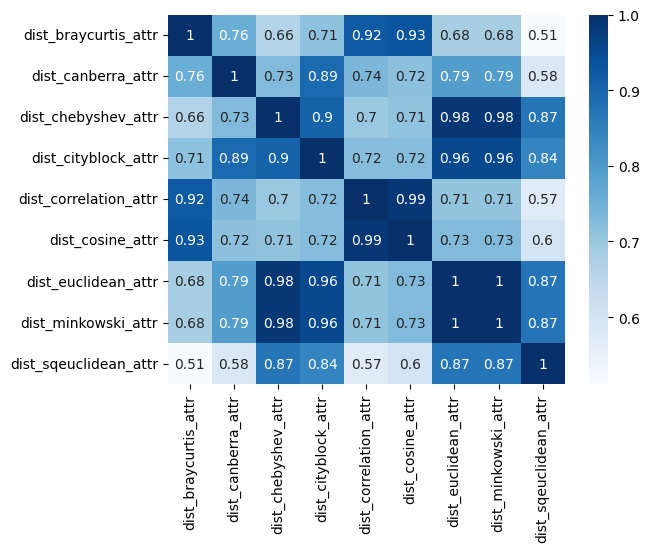

In [414]:
# # import seaborn as sb
# # # df_test = pd.DataFrame()
# # # df_test[columns_text_distance] = train_features.apply(lambda x: pd.Series(calc_additional_distance(x["name1"], x["name2"])), axis=1 )
# corr = df_test.corr()
# sb.heatmap(corr, cmap="Blues", annot=True)

In [60]:
# group_name = "Компьютер"
# pop_characts_df_idf[group_name]#["Частота процессора, ГГц"]
# # values = [i[0] for i in kv_idf_by_models[group_name][1]["Частота процессора, ГГц"]]
# # set(values)
# list_values = list(kv_idf_by_models[group_name][1]["Частота процессора, ГГц"].keys())
# digit_list_values =  list(map(str_to_digital, list_values))
# # digit_list_values
# # list(map(str_to_digital, list_values))
# # kv_idf_by_models[group_name][1]["Частота процессора, ГГц"]
# digit_list_values

In [221]:
# group_name = "Компьютер"
# #
# TOP_N_characts_vector = 50
# top_pop_characts = [i[1] for i in pop_characts_df_idf[group_name][:TOP_N_characts_vector]]
# top_pop_characts
# # sequence_charactes = list(kv_idf_by_models[group_name][0].keys())
# dictonary_charactes_OHE = {}

# for key in top_pop_characts:
#     print(f"key: {key}")
# #     dictonary_charactes_OHE[k] = list
#     # Определяем характеристика хранить катгориальный признак или нет
#     # Общее число встречаемости характеристики во всех товарах
#     count_char_key = kv_idf_by_models[group_name][0][key]
#     # Кол-во уникальное значений в характеристике 
#     unqiue_val_char = len(kv_idf_by_models[group_name][1][key].keys())
#     unqiue_val_char/count_char_key
#     print(f"count_char_key: {count_char_key}")
#     print(f"unqiue_val_char: {unqiue_val_char}")
#     print(f"freq val_char: {unqiue_val_char/count_char_key}")
    
#     print(kv_idf_by_models[group_name][1][key].most_common(2))
    
#     list_values = list(kv_idf_by_models[group_name][1][key].keys())
#     print(f"list_values: {list_values}")
#     if unqiue_val_char < 20 or unqiue_val_char/count_char_key < 0.002:
#         print("Тип: Категориальный")
#     else:
#         print("Тип: Значение")
#     list_values
#     digit_list_values =  list(map(str_to_digital, list_values))
#     if len(set(digit_list_values)) >= len(list_values)*0.8:
#         print("Все значения числа")
#         print(len(set(digit_list_values))/len(list_values))
#     else:
#         print(f"Не все значения числа, len(list_values): {len(list_values)}, len(set(digit_list_values)): {len(set(digit_list_values))}")
#         print(len(set(digit_list_values))/len(list_values))
#     print()
    


# # kv_idf_by_models["Компьютер"][1]["Интерфейсы и разъемы"].keys()
# # # "1.12".isnumeric()
# # # "1.12".isdecimal()
# # number = "1.12"
# # try:
# #     float(number)
# # except ValueError:
# #     print("Not a float")

key: Тип видеокарты
count_char_key: 52469
unqiue_val_char: 3
freq val_char: 5.717661857477749e-05
[('Встроенная', 29632), ('Дискретная', 22326)]
list_values: ['Дискретная', 'Встроенная', 'Гибридная']
Тип: Категориальный
Не все значения числа, len(list_values): 3, len(set(digit_list_values)): 1
0.3333333333333333

key: Тип жесткого диска
count_char_key: 53640
unqiue_val_char: 4
freq val_char: 7.457121551081282e-05
[('SSD', 48620), ('HDD', 14912)]
list_values: ['SSD', 'HDD', 'SSHD', 'eMMC']
Тип: Категориальный
Не все значения числа, len(list_values): 4, len(set(digit_list_values)): 1
0.25

key: Бренд процессора
count_char_key: 54204
unqiue_val_char: 7
freq val_char: 0.00012914176075566378
[('Intel', 38610), ('AMD', 15168)]
list_values: ['Intel', 'AMD', 'Apple', 'MediaTek', 'Qualcomm', 'Broadcom', 'ARM']
Тип: Категориальный
Не все значения числа, len(list_values): 7, len(set(digit_list_values)): 1
0.14285714285714285

key: Бренд графического процессора
count_char_key: 53255
unqiue_val_cha

In [326]:
# for k in kv_idf_by_models["Компьютер"][0]:
#     print(f"Charact: {k}")
#     count_char_key = kv_idf_by_models["Компьютер"][0][k]
#     unqiue_val_char = len(kv_idf_by_models["Компьютер"][1][k].keys())
#     print(f"count_char_key: {count_char_key}")
#     print(f"unqiue_val_char: {unqiue_val_char}")
#     print(kv_idf_by_models["Компьютер"][1][k].most_common(2))
#     print(f"freq val_char: {unqiue_val_char/count_char_key}")
#     print()
# #     if 
    
# #     break


Charact: Размер упаковки (Длина х Ширина х Высота), см
count_char_key: 393
unqiue_val_char: 242
[('55 x 10 x 39', 10), ('60 x 40 x 10', 8)]
freq val_char: 0.6157760814249363

Charact: Число портов USB 3.2 Gen 2
count_char_key: 4900
unqiue_val_char: 7
[('2', 1987), ('1', 1960)]
freq val_char: 0.0014285714285714286

Charact: Цвет товара
count_char_key: 59243
unqiue_val_char: 52
[('черный', 33248), ('серый', 10968)]
freq val_char: 0.0008777408301402697

Charact: Скорость вращения шпинделя HDD
count_char_key: 1962
unqiue_val_char: 8
[('5400 об/мин', 1585), ('10000 об/мин', 167)]
freq val_char: 0.004077471967380225

Charact: Покрытие экрана
count_char_key: 27560
unqiue_val_char: 4
[('Матовое', 23744), ('Глянцевое', 3733)]
freq val_char: 0.00014513788098693758

Charact: Общий объем HDD, ГБ
count_char_key: 19146
unqiue_val_char: 27
[('1000', 5355), ('2000', 3888)]
freq val_char: 0.0014102162331557505

Charact: Форм-фактор SSD
count_char_key: 22536
unqiue_val_char: 9
[('M.2', 15497), ('2.5"', 

In [327]:
# train_features[top_chars_columns]

In [328]:
# kv_idf_by_models["Расходник для печати"][0]

In [329]:
# # group_cat = "Видеонаблюдение"
# group_cat = "Компьютер"
# # group_cat = "Смартфоны, планшеты, мобильные телефоны"
# # group_cat = "Сетевое оборудование"
# # group_cat = "Телевизоры"
# # group_cat = "Материнская плата"
# group_cat = "Расходник для печати"


# pop_characts_df_idf = {}
# # for group_cat in fix_cat3_for_model:
# for group_cat in ["Расходник для печати"]:
#     print(group_cat)
#     # # train_features.iloc[:20].apply(lambda x: products_tf_idf(x["characteristic_attributes_mapping1"], x["characteristic_attributes_mapping2"], x["cat_level_3_1"],x["cat_level_3_2"])), axis=1)
#     test_char = train_features[train_features["cat3_grouped_model"] == group_cat].iloc[0]["characteristic_attributes_mapping2"]
#     test_char = json.loads(test_char)

#     items_in_group = kv_idf_by_models[group_cat][2]

#     attr_list = []

#     for k in test_char:
#         counts_k = kv_idf_by_models[group_cat][0][k]
#         key_df = counts_k/items_in_group

#         df_idf_values = []
#         for v in test_char[k]:
#             counts_v = kv_idf_by_models[group_cat][1][k][v]
#             value_idf = np.log(counts_k/counts_v)
#             df_idf_val = key_df * np.log(counts_k/counts_v)
#             df_idf_values.append(df_idf_val)
#         df_idf = np.mean(df_idf_values)
#         attr_list.append((df_idf, k))
#     attr_list = sorted(attr_list, reverse=True)
#     display(attr_list)
#     pop_characts_df_idf[group_cat] = attr_list[:20]


In [330]:
# # Формируем топ-список аттрибутов для каждой категории
# pop_characts = {}
# TOP_N_characts = 20
# from collections import Counter

# for cat_name in fix_cat3:
#     cat_characts = Counter()
#     json_characts = attr_df[attr_df["cat_level_3"] == cat_name]["characteristic_attributes_mapping"].values
#     for json_ch in json_characts:
#         if json_ch is not None:
#             json_ch = json.loads(json_ch)
#             cat_characts.update(json_ch.keys())
#     select_cats = [cat_name[0] for cat_name in cat_characts.most_common(TOP_N_characts)]
#     pop_characts[cat_name] = select_cats

In [331]:
# %%time
# def code_all_characteristics(attr_1, attr_2, group_cat, cat_level_3_1, cat_level_3_2, n_rest=40):
# #     print(characts_group[group_cat])
#     # Для категории прочее, надо выбрать ограничение кол-ва характеристик
#     # n_rest = 40
#     if group_cat == "rest":
#         vec_attr = np.zeros(n_rest)
#     else:
#         vec_attr = np.zeros(len(characts_group[group_cat]))
#     if attr_1 is None or attr_2 is None:
#         return vec_attr
#     attr_1 = json.loads(attr_1)
#     attr_2 = json.loads(attr_2)
#     if cat_level_3_1 != cat_level_3_2:
#         return vec_attr
    
#     if group_cat == "rest":
#         for i, cat_name in enumerate(sorted(attr_1.keys())):
#             if i == n_rest:
#                 break
#             if cat_name in attr_2:
#                 if attr_1[cat_name] == attr_2[cat_name]:
#                     vec_attr[i] = 1
#                 else:
#                     vec_attr[i] = text_title_iou_filter(" ".join(attr_1[cat_name]), " ".join(attr_2[cat_name][0]))
#     else:
#         for i, cat_name in enumerate(characts_group[group_cat]):
#             if cat_name in attr_1 and cat_name in attr_2:
#                 if attr_1[cat_name] == attr_2[cat_name]:
#                     vec_attr[i] = 1
#                 else:
#                     vec_attr[i] = text_title_iou_filter(" ".join(attr_1[cat_name]), " ".join(attr_2[cat_name][0]))
#     return vec_attr

# for group_cat in kv_idf_by_models.keys():
# #     train_features_group_cat = train_features.copy()
#     train_features_group_cat = train_features[train_features["cat3_grouped_model"] == group_cat].copy()
#     if group_cat == "rest":
#          n_characters = 40
#     else: 
#         n_characters = len(characts_group[group_cat])
#         train_features_group_cat[[f"Group_char_{i+1}" for i in range(n_characters)]] = train_features_group_cat.apply(lambda x: pd.Series(code_all_characteristics(x["characteristic_attributes_mapping1"], x["characteristic_attributes_mapping2"], x["cat3_grouped_model"], x["cat_level_3_1"],x["cat_level_3_2"])), axis=1)
#     break
    

In [332]:
# ### Отсортированный список всех характеристик внутри категории
# characts_group = {}
# for group_cat in kv_idf_by_models.keys():
#     characts_group[group_cat] = sorted(list(kv_idf_by_models[group_cat][1].keys()))
# #     print(f"group_cat: {group_cat}, count characts: {len(characts_group[group_cat])}")

In [333]:
# %%time
# def code_all_characteristics(attr_1, attr_2, group_cat, cat_level_3_1, cat_level_3_2, n_rest=40):
# #     print(characts_group[group_cat])
#     # Для категории прочее, надо выбрать ограничение кол-ва характеристик
#     # n_rest = 40
#     if group_cat == "rest":
#         vec_attr = np.zeros(n_rest)
#     else:
#         vec_attr = np.zeros(len(characts_group[group_cat]))
#     if attr_1 is None or attr_2 is None:
#         return vec_attr
#     attr_1 = json.loads(attr_1)
#     attr_2 = json.loads(attr_2)
#     if cat_level_3_1 != cat_level_3_2:
#         return vec_attr
    
#     if group_cat == "rest":
#         for i, cat_name in enumerate(sorted(attr_1.keys())):
#             if i == n_rest:
#                 break
#             if cat_name in attr_2:
#                 if attr_1[cat_name] == attr_2[cat_name]:
#                     vec_attr[i] = 1
#                 else:
#                     vec_attr[i] = text_title_iou_filter(" ".join(attr_1[cat_name]), " ".join(attr_2[cat_name][0]))
#     else:
#         for i, cat_name in enumerate(characts_group[group_cat]):
#             if cat_name in attr_1 and cat_name in attr_2:
#                 if attr_1[cat_name] == attr_2[cat_name]:
#                     vec_attr[i] = 1
#                 else:
#                     vec_attr[i] = text_title_iou_filter(" ".join(attr_1[cat_name]), " ".join(attr_2[cat_name][0]))
#     return vec_attr

# for group_cat in kv_idf_by_models.keys():
# #     train_features_group_cat = train_features.copy()
#     train_features_group_cat = train_features[train_features["cat3_grouped_model"] == group_cat].copy()
#     if group_cat == "rest":
#          n_characters = 40
#     else: 
#         n_characters = len(characts_group[group_cat])
#         train_features_group_cat[[f"Group_char_{i+1}" for i in range(n_characters)]] = train_features_group_cat.apply(lambda x: pd.Series(code_all_characteristics(x["characteristic_attributes_mapping1"], x["characteristic_attributes_mapping2"], x["cat3_grouped_model"], x["cat_level_3_1"],x["cat_level_3_2"])), axis=1)
#     break
    

In [334]:
# name1, name2, name_bert_641, name_bert_642 = train_features.loc[7, ["name1", "name2", "name_bert_641", "name_bert_642"]].values

# name_bert_642.shape
# emb1 = embed_bert_cls(name1, nlp_model, tokenizer)
# emb2 = embed_bert_cls(name2, nlp_model, tokenizer)

# cos_value =  cosine(emb1, emb2)
# sqeuclidean_value = pairwise_distances(emb1[None], emb2[None], metric="sqeuclidean")
# iou_name = text_title_iou_filter(name1, name2)

# cos_value2 =  cosine(name_bert_641, name_bert_642)
# sqeuclidean_value2 = pairwise_distances(name_bert_641[None], name_bert_642[None], metric="sqeuclidean")

# # name1, name2, (1- cos_value), (1 -sqeuclidean_value[0][0]), iou_name, (1- cos_value2), (1-sqeuclidean_value2[0][0])
# print(f"name1: {name1}")
# print(f"name2: {name2}")
# print(f"Схожесть IoU: {iou_name}")
# print(f"Схожесть косинусное расстояние эмбеддингов из МиниБерт: {(1- cos_value)}")
# print(f"Схожесть sqeuclidean_value расстояние эмбеддингов из МиниБерт: {(1 -sqeuclidean_value[0][0])}")
# print(f"Схожесть косинусное расстояние эмбеддингов полученные от Озон: {(1- cos_value2)}")
# print(f"Схожесть sqeuclidean_value расстояние эмбеддингов полученные от Озон: {(1-sqeuclidean_value2[0][0])}")


In [335]:
# def create_emb_by_characteristic(text1, text2):
#     json.loads(attr_1)
#     emb_text1 = embed_bert_cls(text1, nlp_model, tokenizer)
#     emb_text2 = embed_bert_cls(text2, nlp_model, tokenizer)
#     cos_sim = 1 - cosine(emb_text1, emb_text2)
#     return cos_sim

# # train_features["cos_sim_characteristic"] = 
# train_features.loc[:100].apply(lambda x: create_emb_by_characteristic(x["characteristic_attributes_mapping1"], x["characteristic_attributes_mapping2"]), axis=1)

In [336]:
# text_title_iou_filter('Аккумулятор для Xiaomi Redmi Note 4 / Redmi Note 4 Pro (BN41)', 'Redmi Note 4/Note 4 Pro')


In [337]:
# attr_1, attr_2 =train_features.loc[7,["characteristic_attributes_mapping1","characteristic_attributes_mapping2"]].values
# categories_1 = json.loads(attr_1)
# categories_2 = json.loads(attr_2)
# list(sorted(categories_1.keys())), list(sorted(categories_2.keys()))
# print(split_attributes(attr_1, attr_2))



# for key in categories_1:
#     if key in categories_2:
#         print(f"{key}: {categories_1[key]} - {categories_2[key]} - {categories_2[key][0] == categories_1[key][0]}")
#         print(categories_2[key][0] in categories_1[key][0])
#         print()
    
# list(train_features.columns)

## Обучение моделей

In [52]:
def plot_feature_importance(importance,names,model_type, top_n=50):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
#     display(fi_df.sort_values(by=['feature_importance']))
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df[:top_n]
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

### Метрика

In [53]:
# Метрика
from sklearn.metrics import precision_recall_curve, auc

def pr_auc_macro(
    target_df: pd.DataFrame,
    predictions_df: pd.DataFrame,
    prec_level: float = 0.75,
    cat_column: str = "cat3_grouped"
) -> float:
    
    df = target_df.merge(predictions_df, on=["variantid1", "variantid2"])
    
    y_true = df["target"]
    y_pred = df["scores"]
    categories = df[cat_column]
    
    names = []
    weights = []
    pr_aucs = []
    cat_counts = []
    
    unique_cats, counts = np.unique(categories, return_counts=True)

    for i, category in enumerate(unique_cats):
        names.append(category)
        cat_counts.append(counts[i])
#         print(f"category: {category}")
        cat_idx = np.where(categories == category)[0]
        y_pred_cat = y_pred[cat_idx]
        y_true_cat = y_true[cat_idx]

        y, x, thr = precision_recall_curve(y_true_cat, y_pred_cat)
        gt_prec_level_idx = np.where(y >= prec_level)[0]
        lt_prec_level_idx = np.where(y < prec_level)[0]
#         print(f"gt_prec_level_idx: {len(gt_prec_level_idx)}, lt_prec_level_idx: {len(lt_prec_level_idx)}")
        try:
            pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
#             pr_auc_prec_level_t = auc(x, y)
#             print(pr_auc_prec_level)
#             print(f"pr_auc_prec_level: {pr_auc_prec_level}, pr_auc_prec_level_t: {pr_auc_prec_level_t}")
            if not np.isnan(pr_auc_prec_level):
                pr_aucs.append(pr_auc_prec_level)
                weights.append(counts[i] / len(categories))
                
        except ValueError as err:
            pr_aucs.append(0)
            weights.append(counts[i] / len(categories))
        
#         print(f"w: {counts[i] / len(categories)}")
#     print(len(names), len(weights), len(pr_aucs), len(cat_counts))
    score_df = pd.DataFrame({"cat_name":names, "weight":weights, "score":pr_aucs, "counts":cat_counts})
#     display(score_df.sort_values(by="score").head(10))
    display(score_df.sort_values(by="score"))
    return np.average(pr_aucs, weights=weights)

Choose features

In [54]:
# cat_features=["cat3_grouped", "cat3_grouped_model", "cat4_grouped_id"]
# cat_features=["cat3_grouped_id", "cat4_grouped_id"]
cat_features=["cat4_grouped_id"]
# embedding_features = ["main_pic_embeddings_resnet_v11", "main_pic_embeddings_resnet_v12", "name_bert_641", "name_bert_642"]
feats = ["iou_names", "iou_names2", "iou_names2_eng"] \
         + ["is_equal_cat_2", "is_equal_cat_3", "is_equal_cat_4" ] \
         + colors_columns_name_1 + colors_columns_name_2 \
         + colors_columns_name \
         + ["color_dist_euclidean", "color_sim_cosine", "iou_color"] \
         + ['pic_dist_0_perc_cosine', 'pic_dist_25_perc_cosine', 'pic_dist_50_perc_cosine', 'pic_dist_100_perc_cosine'] \
         + ['main_pic_dist_sqeuclidean'] \
         + ['pic_dist_0_perc_sqeuclidean'] \
         + ["euclidean_name_bert_dist", "cosine_name_bert_dist"] \
         + ["iou_attr", "iou_attr_weight", "iou_dict", "iou_attr_mat_dict"] \
         + top_chars_columns \
         + ["anti_words_values"] \
         + ["iou_2gram_name", "iou_3gram_name", "iou_4gram_name", "iou_5gram_name", "iou_2gram_eng_name", "iou_3gram_eng_name", "iou_4gram_eng_name", "iou_5gram_eng_name", ] \
         + ["attr_2_gram", "attr_3_gram", "attr_4_gram", "attr_5_gram"] \
         + columns_text_distance + columns_text_distance_eng \
         + columns_attr_distance \
#          + attr_distance_columns \

# important_chars = important_chars_1_columns + important_chars_2_columns
# important_chars_1_columns = [f"important_char_1_{i}" for i in range(N_characts_vector)]
# important_chars_2_columns = [f"important_char_2_{i}" for i in range(N_characts_vector)]


##### Обучение для каждой категории свою модель

In [155]:
from imblearn.over_sampling import RandomOverSampler, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.utils.class_weight import compute_class_weight

from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsembleClassifier
from imblearn.ensemble import RUSBoostClassifier, BalancedRandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import log_loss, roc_auc_score

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import xgboost as xgb
from lightgbm import LGBMClassifier

class ModelByCat():
    def __init__(self, cat_features=None, k_over_sampler=0.3):
        self.cat_features = cat_features
        self.k_over_sampler = k_over_sampler
        self.auc_score = 0
        self.log_loss = 0

    def create_train_test_by_cat(self, train_features, feats, cat_features):
        self.train_features = train_features
        self.cat_features = cat_features
        self.feats = feats
        
        
        self.main_X_train = self.train_features[self.feats + self.cat_features + ["target", "variantid1", "variantid2", "cat3_grouped_model", "cat3_grouped"]]
        self.main_y_train = self.main_X_train["target"]
        self.main_X_train = self.main_X_train.drop(["target"], axis=1)[self.feats + self.cat_features]
        
        self.X_train_val, self.X_test = train_test_split(
            self.train_features[self.feats + self.cat_features + ["target", "variantid1", "variantid2", "cat3_grouped_model", "cat3_grouped"]], 
            test_size=0.1, random_state=42, stratify=self.train_features[["target"]]
        )

        self.X_train, self.X_val = train_test_split(
            self.X_train_val[self.feats + cat_features  + ["target",  "variantid1", "variantid2", "cat3_grouped_model", "cat3_grouped"]], 
            test_size=0.1, random_state=42, stratify=self.X_train_val[["target"]]
        )

        self.y_test = self.X_test[["target", "variantid1", "variantid2"]]
        self.X_test = self.X_test.drop(["target"], axis=1)

        self.y_train = self.X_train["target"]
        self.y_val = self.X_val["target"]

        self.X_train = self.X_train.drop(["target"], axis=1)[self.feats + self.cat_features]
        self.X_val = self.X_val.drop(["target"], axis=1)[self.feats + self.cat_features]
        
        # X_train_val - для использования в кроссвалидации
        self.y_train_val = self.X_train_val["target"]
        self.X_train_val = self.X_train_val.drop(["target"], axis=1)[self.feats + self.cat_features]

        classes = np.unique(self.y_train)
        weights = compute_class_weight(class_weight='balanced', classes=classes, y=self.y_train)
        self.class_weights = dict(zip(classes, weights))        
        print(f"class_weights: {self.class_weights}")
        
        # Sampling
        print(f"before: {self.y_train.value_counts()}")
        self.src_prc_weight = min(self.y_train.value_counts())/max(self.y_train.value_counts())
        print(f"src_prc_weight: {self.src_prc_weight}")
        count_part_undering = self.src_prc_weight + (1 - self.src_prc_weight)*self.k_over_sampler
        print(f"count_part_undering: {count_part_undering}")
        if count_part_undering < 0.9:
            self.X_train, self.y_train = RandomOverSampler(sampling_strategy=count_part_undering, random_state=53).fit_resample(self.X_train, self.y_train)
            print(f"after RandomOverSampler: {self.y_train.value_counts()}")
#         if self.src_prc_weight < 0.70:
#             self.X_train, self.y_train = ADASYN(sampling_strategy=count_part_undering, random_state=53).fit_resample(self.X_train, self.y_train)        
#             print(f"after ADASYN: {self.y_train.value_counts()}")
#         self.X_train, self.y_train = BorderlineSMOTE(sampling_strategy=count_part_undering, random_state=53).fit_resample(self.X_train, self.y_train)
#         print(f"after BorderlineSMOTE: {self.y_train.value_counts()}")
        

        
    def fit_model(self, plot=True, verbose=True, without_val_test=False):
        # BalancedBaggingClassifier (0.63)
        self.model_bbc = BalancedBaggingClassifier(random_state=53, n_estimators=200, max_samples=round(self.src_prc_weight,2))
        self.model_lgbm = LGBMClassifier(reg_alpha=0.5, objective='binary', 
                                         random_state=53)
        
#         self.train_pool = Pool(
#             data=self.X_train[self.feats + self.cat_features],
#             cat_features=self.cat_features,
#             label=self.y_train,
#         )
#         self.eval_pool = Pool(
#             data=self.X_val[self.feats + self.cat_features],
#             cat_features=self.cat_features,
#             label=self.y_val,
#         )       
    
        self.model_cat = CatBoostClassifier(eval_metric =  "AUC", verbose=False, early_stopping_rounds=200, cat_features=["cat4_grouped_id"])
        
        estimators=[
                    ('model_bbc', self.model_bbc), 
                    ('model_cat', self.model_cat), 
                    ("model_lgbm", self.model_lgbm),
                   ]
        # Обучение без валидационной и тестовой выборки, все данные включаются в трейн
        if without_val_test:
            for model_name, clf in estimators:
                if model_name == "model_cat":
                    clf.fit(self.main_X_train, self.main_y_train)
                else:
                    clf.fit(self.main_X_train.values, self.main_y_train.values)
        else:
            for model_name, clf in estimators:
                if model_name == "model_cat":
                    clf.fit(self.X_train, self.y_train)
                    y_pred = clf.predict(self.X_val)
                else:
                    clf.fit(self.X_train.values, self.y_train.values)
                    y_pred = clf.predict(self.X_val.values)
                print(model_name, roc_auc_score(self.y_val, y_pred))

            predict_val = estimators[0][1].predict_proba(self.X_val)[:, 1]
            self.auc_score = metrics.roc_auc_score(y_true=self.y_val, y_score=predict_val)
            self.log_loss = metrics.log_loss(y_true=self.y_val, y_pred=predict_val)
            print(f"first model score_auc: {self.auc_score}")
            print(f"first model score_auc: {self.log_loss}")
        

    def predict_proba(self, X_test):
        predict_model_bbc = self.model_bbc.predict_proba(X_test)[:, 1]
        predict_model_cat = self.model_cat.predict_proba(X_test)[:, 1]
        predict_model_lgbm = self.model_lgbm.predict_proba(X_test)[:, 1]
        mean_predict = np.mean((
            predict_model_bbc  * 1.0,
            predict_model_cat * 1.0,
            predict_model_lgbm * 1.0,
            ), axis=0)        
        return mean_predict

    def predict(self):
        self.X_test["scores"] = self.predict_proba(self.X_test[self.feats + self.cat_features])



In [156]:
%%time
# Финальное обучение без валидации и теста
cats_models = {}
for group_cat in tqdm(fix_cat3_for_model):
    print(f"group_cat: {group_cat}")
    model_by_cat = ModelByCat()
    sub_train = train_features[train_features["cat3_grouped_model"]==group_cat]
    model_by_cat.create_train_test_by_cat(train_features=sub_train, feats=feats, cat_features=cat_features)
    model_by_cat.fit_model(plot=False, verbose=False, without_val_test=True)
    cats_models[group_cat] = model_by_cat


  0%|          | 0/41 [00:00<?, ?it/s]

group_cat: Видеонаблюдение
class_weights: {0.0: 1.4037925264919129, 1.0: 0.7766121567417463}
before: 1.0    3241
0.0    1793
Name: target, dtype: int64
src_prc_weight: 0.5532243134834928
count_part_undering: 0.687257019438445
after RandomOverSampler: 1.0    3241
0.0    2227
Name: target, dtype: int64
group_cat: Запчасти для смартфонов
class_weights: {0.0: 1.204096742349457, 1.0: 0.8550648440238345}
before: 1.0    2853
0.0    2026
Name: target, dtype: int64
src_prc_weight: 0.7101296880476691
count_part_undering: 0.7970907816333683
after RandomOverSampler: 1.0    2853
0.0    2274
Name: target, dtype: int64
group_cat: Кронштейн
class_weights: {0.0: 2.6923076923076925, 1.0: 0.6140350877192983}
before: 1.0    969
0.0    221
Name: target, dtype: int64
src_prc_weight: 0.22807017543859648
count_part_undering: 0.45964912280701753
after RandomOverSampler: 1.0    969
0.0    445
Name: target, dtype: int64
group_cat: Устройство ручного ввода
class_weights: {0.0: 1.414684167350287, 1.0: 0.7733183856

group_cat: Мониторы и запчасти
class_weights: {0.0: 1.0880208333333334, 1.0: 0.9251550044286979}
before: 1.0    1129
0.0     960
Name: target, dtype: int64
src_prc_weight: 0.8503100088573959
count_part_undering: 0.8952170062001772
after RandomOverSampler: 1.0    1129
0.0    1010
Name: target, dtype: int64
group_cat: Смартфоны, планшеты, мобильные телефоны
class_weights: {0.0: 0.7895663708718325, 1.0: 1.3633599241766052}
before: 0.0    21862
1.0    12661
Name: target, dtype: int64
src_prc_weight: 0.5791327417436648
count_part_undering: 0.7053929192205654
after RandomOverSampler: 0.0    21862
1.0    15421
Name: target, dtype: int64
group_cat: Зарядные устройства и док-станции
class_weights: {0.0: 1.1400313356835097, 1.0: 0.8906058751529988}
before: 1.0    3268
0.0    2553
Name: target, dtype: int64
src_prc_weight: 0.7812117503059975
count_part_undering: 0.8468482252141982
after RandomOverSampler: 1.0    3268
0.0    2767
Name: target, dtype: int64
group_cat: Видеорегистратор
class_weights

In [133]:
%%time
# Финальное обучение без валидации и теста
cats_models = {}
for group_cat in tqdm(fix_cat3_for_model):
    print(f"group_cat: {group_cat}")
    model_by_cat = ModelByCat()
    sub_train = train_features[train_features["cat3_grouped_model"]==group_cat]
    model_by_cat.create_train_test_by_cat(train_features=sub_train, feats=feats, cat_features=cat_features)
    model_by_cat.fit_model(plot=False, verbose=False, without_val_test=True)
    cats_models[group_cat] = model_by_cat


  0%|          | 0/41 [00:00<?, ?it/s]

group_cat: Видеонаблюдение
class_weights: {0.0: 1.4037925264919129, 1.0: 0.7766121567417463}
before: 1.0    3241
0.0    1793
Name: target, dtype: int64
src_prc_weight: 0.5532243134834928
count_part_undering: 0.5979018821351435
after RandomOverSampler: 1.0    3241
0.0    1937
Name: target, dtype: int64
group_cat: Запчасти для смартфонов
class_weights: {0.0: 1.204096742349457, 1.0: 0.8550648440238345}
before: 1.0    2853
0.0    2026
Name: target, dtype: int64
src_prc_weight: 0.7101296880476691
count_part_undering: 0.7391167192429021
after RandomOverSampler: 1.0    2853
0.0    2108
Name: target, dtype: int64
group_cat: Кронштейн
class_weights: {0.0: 2.6923076923076925, 1.0: 0.6140350877192983}
before: 1.0    969
0.0    221
Name: target, dtype: int64
src_prc_weight: 0.22807017543859648
count_part_undering: 0.30526315789473685
after RandomOverSampler: 1.0    969
0.0    295
Name: target, dtype: int64
group_cat: Устройство ручного ввода
class_weights: {0.0: 1.414684167350287, 1.0: 0.773318385

group_cat: Мониторы и запчасти
class_weights: {0.0: 1.0880208333333334, 1.0: 0.9251550044286979}
before: 1.0    1129
0.0     960
Name: target, dtype: int64
src_prc_weight: 0.8503100088573959
count_part_undering: 0.8652790079716564
after RandomOverSampler: 1.0    1129
0.0     976
Name: target, dtype: int64
group_cat: Смартфоны, планшеты, мобильные телефоны
class_weights: {0.0: 0.7895663708718325, 1.0: 1.3633599241766052}
before: 0.0    21862
1.0    12661
Name: target, dtype: int64
src_prc_weight: 0.5791327417436648
count_part_undering: 0.6212194675692984
after RandomOverSampler: 0.0    21862
1.0    13581
Name: target, dtype: int64
group_cat: Зарядные устройства и док-станции
class_weights: {0.0: 1.1400313356835097, 1.0: 0.8906058751529988}
before: 1.0    3268
0.0    2553
Name: target, dtype: int64
src_prc_weight: 0.7812117503059975
count_part_undering: 0.8030905752753978
after RandomOverSampler: 1.0    3268
0.0    2624
Name: target, dtype: int64
group_cat: Видеорегистратор
class_weights

In [102]:
%%time

log_log_loss = []
log_auc = []
cats_models = {}
for group_cat in tqdm(fix_cat3_for_model):
# for group_cat in ["Компьютер"]:
    print(f"group_cat: {group_cat}")
    model_by_cat = ModelByCat()
    sub_train = train_features[train_features["cat3_grouped_model"]==group_cat]
    
    model_by_cat.create_train_test_by_cat(train_features=sub_train, feats=feats, cat_features=cat_features)
    model_by_cat.fit_model(plot=False, verbose=False)
    model_by_cat.predict()
    
    log_log_loss.append(model_by_cat.log_loss)
    log_auc.append(model_by_cat.auc_score)
    
    cats_models[group_cat] = model_by_cat
    print(f"logloss: {model_by_cat.log_loss}")
    print(f"auc_score: {model_by_cat.auc_score}")
    print()

print(f"mean log_loss: {np.mean(log_log_loss)}")
print(f"mean log_auc: {np.mean(log_auc)}")  


  0%|          | 0/41 [00:00<?, ?it/s]

group_cat: Видеонаблюдение
class_weights: {0.0: 1.4037925264919129, 1.0: 0.7766121567417463}
before: 1.0    3241
0.0    1793
Name: target, dtype: int64
src_prc_weight: 0.5532243134834928
count_part_undering: 0.5979018821351435
after RandomOverSampler: 1.0    3241
0.0    1937
Name: target, dtype: int64
model_bbc 0.7233333333333334
model_cat 0.7094444444444445
model_lgbm 0.6919444444444445
first model score_auc: 0.7985347222222222
first model score_auc: 0.5406913939250824


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


logloss: 0.5406913939250824
auc_score: 0.7985347222222222

group_cat: Запчасти для смартфонов
class_weights: {0.0: 1.204096742349457, 1.0: 0.8550648440238345}
before: 1.0    2853
0.0    2026
Name: target, dtype: int64
src_prc_weight: 0.7101296880476691
count_part_undering: 0.7391167192429021
after RandomOverSampler: 1.0    2853
0.0    2108
Name: target, dtype: int64
model_bbc 0.7404176321152397
model_cat 0.7697509840596298
model_lgbm 0.7545922782725218
first model score_auc: 0.807180145724575
first model score_auc: 0.6012420222771822
logloss: 0.6012420222771822
auc_score: 0.807180145724575

group_cat: Кронштейн


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


class_weights: {0.0: 2.6923076923076925, 1.0: 0.6140350877192983}
before: 1.0    969
0.0    221
Name: target, dtype: int64
src_prc_weight: 0.22807017543859648
count_part_undering: 0.30526315789473685
after RandomOverSampler: 1.0    969
0.0    295
Name: target, dtype: int64
model_bbc 0.7551851851851851
model_cat 0.7568518518518519
model_lgbm 0.6875925925925925
first model score_auc: 0.8088888888888889
first model score_auc: 0.4471819272547978


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


logloss: 0.4471819272547978
auc_score: 0.8088888888888889

group_cat: Устройство ручного ввода
class_weights: {0.0: 1.414684167350287, 1.0: 0.7733183856502243}
before: 1.0    4460
0.0    2438
Name: target, dtype: int64
src_prc_weight: 0.5466367713004484
count_part_undering: 0.5919730941704036
after RandomOverSampler: 1.0    4460
0.0    2640
Name: target, dtype: int64
model_bbc 0.7809412569932151
model_cat 0.7578673669801215
model_lgbm 0.7516478693012736
first model score_auc: 0.8488349601237948
first model score_auc: 0.48045465373301943


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


logloss: 0.48045465373301943
auc_score: 0.8488349601237948

group_cat: Запчасти для ноутбуков
class_weights: {0.0: 0.7572608200455581, 1.0: 1.471776425013835}
before: 0.0    3512
1.0    1807
Name: target, dtype: int64
src_prc_weight: 0.5145216400911162
count_part_undering: 0.5630694760820046
after RandomOverSampler: 0.0    3512
1.0    1977
Name: target, dtype: int64
model_bbc 0.7491443040551717
model_cat 0.7550991843849805
model_lgbm 0.76007430876309
first model score_auc: 0.8426601010293799
first model score_auc: 0.47797358610052804
logloss: 0.47797358610052804
auc_score: 0.8426601010293799

group_cat: Коврик для мыши


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


class_weights: {0.0: 1.143312101910828, 1.0: 0.8886138613861386}
before: 1.0    606
0.0    471
Name: target, dtype: int64
src_prc_weight: 0.7772277227722773
count_part_undering: 0.7995049504950495
after RandomOverSampler: 1.0    606
0.0    484
Name: target, dtype: int64
model_bbc 0.9128959276018099
model_cat 0.910633484162896
model_lgbm 0.8936651583710407
first model score_auc: 0.9582861990950227
first model score_auc: 0.27579646746705266


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


logloss: 0.27579646746705266
auc_score: 0.9582861990950227

group_cat: Защитные пленки и стекла
class_weights: {0.0: 0.5987012987012987, 1.0: 3.0328947368421053}
before: 0.0    3465
1.0     684
Name: target, dtype: int64
src_prc_weight: 0.1974025974025974
count_part_undering: 0.27766233766233767
after RandomOverSampler: 0.0    3465
1.0     962
Name: target, dtype: int64
model_bbc 0.6543496045814017
model_cat 0.6372716116716662
model_lgbm 0.6320902645214072
first model score_auc: 0.7014419143714208
first model score_auc: 0.5611895588078847
logloss: 0.5611895588078847
auc_score: 0.7014419143714208

group_cat: Наушники и гарнитуры


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


class_weights: {0.0: 3.3267684887459805, 1.0: 0.5884402104365136}
before: 1.0    7033
0.0    1244
Name: target, dtype: int64
src_prc_weight: 0.17688042087302716
count_part_undering: 0.25919237878572443
after RandomOverSampler: 1.0    7033
0.0    1822
Name: target, dtype: int64
model_bbc 0.7670502983802217
model_cat 0.7065217391304348
model_lgbm 0.6967178175618074
first model score_auc: 0.8134845620667926
first model score_auc: 0.5044076315059515


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


logloss: 0.5044076315059515
auc_score: 0.8134845620667926

group_cat: Акустика и колонки
class_weights: {0.0: 4.2439024390243905, 1.0: 0.5667752442996743}
before: 1.0    2149
0.0     287
Name: target, dtype: int64
src_prc_weight: 0.13355048859934854
count_part_undering: 0.2201954397394137
after RandomOverSampler: 1.0    2149
0.0     473
Name: target, dtype: int64
model_bbc 0.7411087866108786
model_cat 0.7176385983263598
model_lgbm 0.7207112970711297
first model score_auc: 0.8369508368200836
first model score_auc: 0.5523880267333546
logloss: 0.5523880267333546
auc_score: 0.8369508368200836

group_cat: Рюкзаки, чехлы, сумки


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


class_weights: {0.0: 1.6592592592592592, 1.0: 0.7156549520766773}
before: 1.0    626
0.0    270
Name: target, dtype: int64
src_prc_weight: 0.43130990415335463
count_part_undering: 0.4881789137380192
after RandomOverSampler: 1.0    626
0.0    305
Name: target, dtype: int64
model_bbc 0.9142857142857144
model_cat 0.911904761904762
model_lgbm 0.8714285714285714
first model score_auc: 0.9671428571428572
first model score_auc: 0.32672670044123364
logloss: 0.32672670044123364
auc_score: 0.9671428571428572



D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


group_cat: Процессор
class_weights: {0.0: 0.8759398496240601, 1.0: 1.165}
before: 0.0    665
1.0    500
Name: target, dtype: int64
src_prc_weight: 0.7518796992481203
count_part_undering: 0.7766917293233082
after RandomOverSampler: 0.0    665
1.0    516
Name: target, dtype: int64
model_bbc 0.7290057915057914
model_cat 0.7449324324324325
model_lgbm 0.708976833976834
first model score_auc: 0.8003137065637065
first model score_auc: 0.5424512462810245


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


logloss: 0.5424512462810245
auc_score: 0.8003137065637065

group_cat: Блоки питания
class_weights: {0.0: 2.1522988505747125, 1.0: 0.6513043478260869}
before: 1.0    575
0.0    174
Name: target, dtype: int64
src_prc_weight: 0.3026086956521739
count_part_undering: 0.37234782608695655
after RandomOverSampler: 1.0    575
0.0    214
Name: target, dtype: int64
model_bbc 0.7947368421052632
model_cat 0.6194331983805668
model_lgbm 0.5777327935222673
first model score_auc: 0.8336032388663968
first model score_auc: 0.5415012889904397
logloss: 0.5415012889904397
auc_score: 0.8336032388663968

group_cat: rest


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


class_weights: {0.0: 1.5402010050251256, 1.0: 0.7403381642512077}
before: 1.0    5382
0.0    2587
Name: target, dtype: int64
src_prc_weight: 0.4806763285024155
count_part_undering: 0.532608695652174
after RandomOverSampler: 1.0    5382
0.0    2866
Name: target, dtype: int64
model_bbc 0.7705546265328873
model_cat 0.7663217670011148
model_lgbm 0.7708217205499813
first model score_auc: 0.842272273318469
first model score_auc: 0.5013005592893539


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


logloss: 0.5013005592893539
auc_score: 0.842272273318469

group_cat: Микрофоны и аксессуары
class_weights: {0.0: 2.360655737704918, 1.0: 0.6343612334801763}
before: 1.0    681
0.0    183
Name: target, dtype: int64
src_prc_weight: 0.2687224669603524
count_part_undering: 0.34185022026431716
after RandomOverSampler: 1.0    681
0.0    232
Name: target, dtype: int64
model_bbc 0.8016233766233766
model_cat 0.7805194805194806
model_lgbm 0.7675324675324675
first model score_auc: 0.8821428571428571
first model score_auc: 0.4765747365782998
logloss: 0.4765747365782998
auc_score: 0.8821428571428571

group_cat: Домофон


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


class_weights: {0.0: 1.6709558823529411, 1.0: 0.7135007849293563}
before: 1.0    637
0.0    272
Name: target, dtype: int64
src_prc_weight: 0.42700156985871274
count_part_undering: 0.48430141287284145
after RandomOverSampler: 1.0    637
0.0    308
Name: target, dtype: int64
model_bbc 0.6969483568075117
model_cat 0.6629107981220657
model_lgbm 0.6654929577464789
first model score_auc: 0.7699530516431924
first model score_auc: 0.555010115765143


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


logloss: 0.555010115765143
auc_score: 0.7699530516431924

group_cat: Принтеры и МФУ
class_weights: {0.0: 1.813976377952756, 1.0: 0.6902621722846441}
before: 1.0    1335
0.0     508
Name: target, dtype: int64
src_prc_weight: 0.3805243445692884
count_part_undering: 0.4424719101123596
after RandomOverSampler: 1.0    1335
0.0     590
Name: target, dtype: int64
model_bbc 0.7027804410354745
model_cat 0.623741610738255
model_lgbm 0.6281759348034516
first model score_auc: 0.7498801534036433
first model score_auc: 0.5648173594444458
logloss: 0.5648173594444458
auc_score: 0.7498801534036433

group_cat: Жесткие диски, SSD и сетевые накопители


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


class_weights: {0.0: 0.7974537037037037, 1.0: 1.3404669260700388}
before: 0.0    3456
1.0    2056
Name: target, dtype: int64
src_prc_weight: 0.5949074074074074
count_part_undering: 0.6354166666666667
after RandomOverSampler: 0.0    3456
1.0    2196
Name: target, dtype: int64
model_bbc 0.9030260644104804
model_cat 0.8889647016011646
model_lgbm 0.8789289938136826
first model score_auc: 0.9479450964337699
first model score_auc: 0.29332896511805495
logloss: 0.29332896511805495
auc_score: 0.9479450964337699

group_cat: Батарейки и аккумуляторы


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


class_weights: {0.0: 1.0418346774193548, 1.0: 0.9613953488372093}
before: 1.0    3225
0.0    2976
Name: target, dtype: int64
src_prc_weight: 0.9227906976744186
count_part_undering: 0.9305116279069767
model_bbc 0.8372251008455839
model_cat 0.8586305254097116
model_lgbm 0.843752637175311
first model score_auc: 0.8805422876335465
first model score_auc: 0.5138887917688585


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


logloss: 0.5138887917688585
auc_score: 0.8805422876335465

group_cat: Компьютер
class_weights: {0.0: 0.5668135336862525, 1.0: 4.24175688976378}
before: 0.0    30413
1.0     4064
Name: target, dtype: int64
src_prc_weight: 0.13362706737250518
count_part_undering: 0.22026436063525467
after RandomOverSampler: 0.0    30413
1.0     6698
Name: target, dtype: int64
model_bbc 0.7592941305879364
model_cat 0.6685350957370747
model_lgbm 0.6745027852928158


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


first model score_auc: 0.8020978741681443
first model score_auc: 0.48703319157878466


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


logloss: 0.48703319157878466
auc_score: 0.8020978741681443

group_cat: Расходник для печати
class_weights: {0.0: 0.9008780487804878, 1.0: 1.1236310537843757}
before: 0.0    10250
1.0     8218
Name: target, dtype: int64
src_prc_weight: 0.8017560975609757
count_part_undering: 0.8215804878048781
after RandomOverSampler: 0.0    10250
1.0     8421
Name: target, dtype: int64
model_bbc 0.847181526809609
model_cat 0.862319899760267
model_lgbm 0.8568434485006833


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


first model score_auc: 0.9045231929393687
first model score_auc: 0.4216743092719181


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


logloss: 0.4216743092719181
auc_score: 0.9045231929393687

group_cat: Аксессуары для фото и видеотехники
class_weights: {0.0: 0.8189858490566038, 1.0: 1.2837338262476894}
before: 0.0    848
1.0    541
Name: target, dtype: int64
src_prc_weight: 0.6379716981132075
count_part_undering: 0.6741745283018867
after RandomOverSampler: 0.0    848
1.0    571
Name: target, dtype: int64
model_bbc 0.9039473684210527
model_cat 0.9039473684210527
model_lgbm 0.8925438596491229
first model score_auc: 0.9554385964912281
first model score_auc: 0.26239158160977544


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


logloss: 0.26239158160977544
auc_score: 0.9554385964912281

group_cat: Кабели и переходники
class_weights: {0.0: 0.683015363835894, 1.0: 1.8660055350553506}
before: 0.0    11846
1.0     4336
Name: target, dtype: int64
src_prc_weight: 0.36603072767178796
count_part_undering: 0.42942765490460916
after RandomOverSampler: 0.0    11846
1.0     5087
Name: target, dtype: int64
model_bbc 0.8576853278386375
model_cat 0.8494992076169592
model_lgbm 0.8476757814346071


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


first model score_auc: 0.9103394171967599
first model score_auc: 0.3494443839934969


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


logloss: 0.3494443839934969
auc_score: 0.9103394171967599

group_cat: Смарт-часы
class_weights: {0.0: 1.7924328147100423, 1.0: 0.6934336525307797}
before: 1.0    7310
0.0    2828
Name: target, dtype: int64
src_prc_weight: 0.38686730506155953
count_part_undering: 0.4481805745554036
after RandomOverSampler: 1.0    7310
0.0    3276
Name: target, dtype: int64
model_bbc 0.7508304541644142
model_cat 0.7151973112087808
model_lgbm 0.7182723419590884


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


first model score_auc: 0.8149849969837277
first model score_auc: 0.4995584100453037


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


logloss: 0.4995584100453037
auc_score: 0.8149849969837277

group_cat: Видеокарты и графические ускорители
class_weights: {0.0: 1.2865921787709498, 1.0: 0.8178267045454546}
before: 1.0    1408
0.0     895
Name: target, dtype: int64
src_prc_weight: 0.6356534090909091
count_part_undering: 0.6720880681818182
after RandomOverSampler: 1.0    1408
0.0     946
Name: target, dtype: int64
model_bbc 0.6878205128205128
model_cat 0.6826923076923077
model_lgbm 0.6624358974358974
first model score_auc: 0.7697115384615385
first model score_auc: 0.5530574840818574
logloss: 0.5530574840818574
auc_score: 0.7697115384615385

group_cat: Карты памяти и флешки


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


class_weights: {0.0: 0.73681640625, 1.0: 1.5556701030927835}
before: 0.0    2048
1.0     970
Name: target, dtype: int64
src_prc_weight: 0.4736328125
count_part_undering: 0.52626953125
after RandomOverSampler: 0.0    2048
1.0    1077
Name: target, dtype: int64
model_bbc 0.8425925925925926
model_cat 0.8411306042884991
model_lgbm 0.8155458089668616
first model score_auc: 0.8928484405458089
first model score_auc: 0.4041029012383889
logloss: 0.4041029012383889
auc_score: 0.8928484405458089

group_cat: Оперативная память
class_weights: {0.0: 0.6211940298507462, 1.0: 2.562807881773399}
before: 0.0    1675
1.0     406
Name: target, dtype: int64
src_prc_weight: 0.24238805970149255
count_part_undering: 0.3181492537313433


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


after RandomOverSampler: 0.0    1675
1.0     532
Name: target, dtype: int64
model_bbc 0.855377302436126
model_cat 0.8119429590017825
model_lgbm 0.8177064765300059


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


first model score_auc: 0.8939988116458705
first model score_auc: 0.3539684470092024
logloss: 0.3539684470092024
auc_score: 0.8939988116458705

group_cat: Системы охлаждения для компьютеров
class_weights: {0.0: 1.5049668874172186, 1.0: 0.7487644151565074}
before: 1.0    607
0.0    302
Name: target, dtype: int64
src_prc_weight: 0.4975288303130148
count_part_undering: 0.5477759472817133
after RandomOverSampler: 1.0    607
0.0    332
Name: target, dtype: int64
model_bbc 0.8235294117647058
model_cat 0.7720588235294117
model_lgbm 0.7941176470588235
first model score_auc: 0.8804065743944637
first model score_auc: 0.4594625266407483


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


logloss: 0.4594625266407483
auc_score: 0.8804065743944637

group_cat: Сетевые фильтры, разветвители и удлинители
class_weights: {0.0: 0.8226795096322241, 1.0: 1.2747625508819538}
before: 0.0    1142
1.0     737
Name: target, dtype: int64
src_prc_weight: 0.6453590192644484
count_part_undering: 0.6808231173380035
after RandomOverSampler: 0.0    1142
1.0     777
Name: target, dtype: int64
model_bbc 0.8599001344344152
model_cat 0.8652294987516804
model_lgbm 0.8731035144997119


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


first model score_auc: 0.9102170155559823
first model score_auc: 0.37742085569496386
logloss: 0.37742085569496386
auc_score: 0.9102170155559823

group_cat: Мониторы и запчасти
class_weights: {0.0: 1.0880208333333334, 1.0: 0.9251550044286979}
before: 1.0    1129
0.0     960
Name: target, dtype: int64
src_prc_weight: 0.8503100088573959
count_part_undering: 0.8652790079716564
after RandomOverSampler: 1.0    1129
0.0     976
Name: target, dtype: int64
model_bbc 0.6646639964396974
model_cat 0.6784230826286901
model_lgbm 0.6478267319388814
first model score_auc: 0.714804925085299
first model score_auc: 0.7807249635063381
logloss: 0.7807249635063381
auc_score: 0.714804925085299

group_cat: Смартфоны, планшеты, мобильные телефоны


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


class_weights: {0.0: 0.7895663708718325, 1.0: 1.3633599241766052}
before: 0.0    21862
1.0    12661
Name: target, dtype: int64
src_prc_weight: 0.5791327417436648
count_part_undering: 0.6212194675692984
after RandomOverSampler: 0.0    21862
1.0    13581
Name: target, dtype: int64
model_bbc 0.8236739317000833
model_cat 0.8333220681278662
model_lgbm 0.8300285316931194


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


first model score_auc: 0.8947136340879851
first model score_auc: 0.4219189929839863


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


logloss: 0.4219189929839863
auc_score: 0.8947136340879851

group_cat: Зарядные устройства и док-станции
class_weights: {0.0: 1.1400313356835097, 1.0: 0.8906058751529988}
before: 1.0    3268
0.0    2553
Name: target, dtype: int64
src_prc_weight: 0.7812117503059975
count_part_undering: 0.8030905752753978
after RandomOverSampler: 1.0    3268
0.0    2624
Name: target, dtype: int64
model_bbc 0.6974498506188647
model_cat 0.7188676133938618
model_lgbm 0.6914746052069995
first model score_auc: 0.7666550265782018
first model score_auc: 0.6333180898377647


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


logloss: 0.6333180898377647
auc_score: 0.7666550265782018

group_cat: Видеорегистратор
class_weights: {0.0: 2.719409282700422, 1.0: 0.6126425855513308}
before: 1.0    1052
0.0     237
Name: target, dtype: int64
src_prc_weight: 0.2252851711026616
count_part_undering: 0.3027566539923955
after RandomOverSampler: 1.0    1052
0.0     318
Name: target, dtype: int64
model_bbc 0.7492877492877492
model_cat 0.690883190883191
model_lgbm 0.6823361823361824


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


first model score_auc: 0.8575498575498576
first model score_auc: 0.48389339820781146
logloss: 0.48389339820781146
auc_score: 0.8575498575498576

group_cat: Чехол
class_weights: {0.0: 0.654258653109548, 1.0: 2.1206546275395035}
before: 0.0    14359
1.0     4430
Name: target, dtype: int64
src_prc_weight: 0.308517306219096
count_part_undering: 0.3776655755971864
after RandomOverSampler: 0.0    14359
1.0     5422
Name: target, dtype: int64
model_bbc 0.8052066140962162
model_cat 0.7911470750045846
model_lgbm 0.7825432483648145


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


first model score_auc: 0.8740945351182835
first model score_auc: 0.40395323802755856


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


logloss: 0.40395323802755856
auc_score: 0.8740945351182835

group_cat: Материнская плата
class_weights: {0.0: 0.7786226685796269, 1.0: 1.3972708547888775}
before: 0.0    3485
1.0    1942
Name: target, dtype: int64
src_prc_weight: 0.557245337159254
count_part_undering: 0.6015208034433286
after RandomOverSampler: 0.0    3485
1.0    2096
Name: target, dtype: int64
model_bbc 0.7982342807924203
model_cat 0.7808462532299743
model_lgbm 0.7828919035314384
first model score_auc: 0.8703584075031104
first model score_auc: 0.4882805338433652
logloss: 0.4882805338433652
auc_score: 0.8703584075031104

group_cat: Электронные модули


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


class_weights: {0.0: 0.6125827814569537, 1.0: 2.7205882352941178}
before: 0.0    2265
1.0     510
Name: target, dtype: int64
src_prc_weight: 0.2251655629139073
count_part_undering: 0.3026490066225166
after RandomOverSampler: 0.0    2265
1.0     685
Name: target, dtype: int64
model_bbc 0.7675438596491229
model_cat 0.6847326649958227
model_lgbm 0.6779448621553884


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


first model score_auc: 0.8354566972988026
first model score_auc: 0.47985782645715763
logloss: 0.47985782645715763
auc_score: 0.8354566972988026

group_cat: Телевизоры
class_weights: {0.0: 0.8126470588235294, 1.0: 1.299623706491063}
before: 0.0    1700
1.0    1063
Name: target, dtype: int64
src_prc_weight: 0.6252941176470588
count_part_undering: 0.6627647058823529
after RandomOverSampler: 0.0    1700
1.0    1126
Name: target, dtype: int64
model_bbc 0.7809099018733274
model_cat 0.769536128456735
model_lgbm 0.7616413916146296
first model score_auc: 0.860414808206958
first model score_auc: 0.5619534287086636
logloss: 0.5619534287086636
auc_score: 0.860414808206958

group_cat: ИБП
class_weights: {0.0: 1.941696113074205, 1.0: 0.6734068627450981}
before: 1.0    816
0.0    283
Name: target, dtype: int64
src_prc_weight: 0.34681372549019607
count_part_undering: 0.41213235294117645


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


after RandomOverSampler: 1.0    816
0.0    336
Name: target, dtype: int64
model_bbc 0.8301854395604396
model_cat 0.8116414835164835
model_lgbm 0.7896634615384616
first model score_auc: 0.9131181318681318
first model score_auc: 0.3817265201364249


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


logloss: 0.3817265201364249
auc_score: 0.9131181318681318

group_cat: Игровая приставка
class_weights: {0.0: 15.336065573770492, 1.0: 0.5168508287292818}
before: 1.0    10860
0.0      366
Name: target, dtype: int64
src_prc_weight: 0.03370165745856354
count_part_undering: 0.1303314917127072
after RandomOverSampler: 1.0    10860
0.0     1415
Name: target, dtype: int64
model_bbc 0.6343888293895367
model_cat 0.5694424798431911
model_lgbm 0.5589043587204721
first model score_auc: 0.7091357326166468
first model score_auc: 0.556094222889545


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


logloss: 0.556094222889545
auc_score: 0.7091357326166468

group_cat: Оптические приборы
class_weights: {0.0: 1.501974333662389, 1.0: 0.7495073891625615}
before: 1.0    2030
0.0    1013
Name: target, dtype: int64
src_prc_weight: 0.49901477832512314
count_part_undering: 0.5491133004926109
after RandomOverSampler: 1.0    2030
0.0    1114
Name: target, dtype: int64
model_bbc 0.8473451327433629
model_cat 0.8407079646017698
model_lgbm 0.838495575221239
first model score_auc: 0.907471219359386
first model score_auc: 0.4073912805608634
logloss: 0.4073912805608634
auc_score: 0.907471219359386

group_cat: Умный дом
class_weights: {0.0: 0.9425162689804772, 1.0: 1.0649509803921569}
before: 0.0    461
1.0    408
Name: target, dtype: int64
src_prc_weight: 0.8850325379609545
count_part_undering: 0.896529284164859
after RandomOverSampler: 0.0    461
1.0    413
Name: target, dtype: int64


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


model_bbc 0.8645299145299146
model_cat 0.85491452991453
model_lgbm 0.8438034188034188
first model score_auc: 0.8775641025641027
first model score_auc: 0.7541467991659658
logloss: 0.7541467991659658
auc_score: 0.8775641025641027

group_cat: Сетевое оборудование


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


class_weights: {0.0: 2.0103092783505154, 1.0: 0.6655290102389079}
before: 1.0    1758
0.0     582
Name: target, dtype: int64
src_prc_weight: 0.3310580204778157
count_part_undering: 0.39795221843003414
after RandomOverSampler: 1.0    1758
0.0     699
Name: target, dtype: int64
model_bbc 0.7435897435897435
model_cat 0.7205128205128205
model_lgbm 0.7282051282051281
first model score_auc: 0.8210650887573964
first model score_auc: 0.47940336916493637
logloss: 0.47940336916493637
auc_score: 0.8210650887573964

mean log_loss: 0.481895165515525
mean log_auc: 0.8470006457918945
Wall time: 27min 51s


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [103]:

global_y_test = pd.DataFrame()
global_X_test = global_y_test
for group_cat in fix_cat3_for_model:
# for group_cat in ["Защитные пленки и стекла", "Компьютер", "Запчасти для ноутбуков"]:
# for group_cat in ["Компьютер", "Компьютер.Системный блок","Компьютер.Ноутбук" ]:
# for group_cat in ["Компьютер"]:
    global_y_test = pd.concat((global_y_test, cats_models[group_cat].y_test))
    global_X_test = pd.concat((global_X_test, cats_models[group_cat].X_test))
global_y_test.shape, global_X_test.shape

pr_auc_macro_metr = pr_auc_macro(
    target_df=global_y_test, 
    predictions_df=global_X_test,
    prec_level=0.75,
    cat_column="cat3_grouped_model"    
#     cat_column="cat3_grouped"
)

pr_auc_macro_metr

,cat_name,weight,score,counts
13,Защитные пленки и стекла,0.016727,0.158904,513
19,Компьютер,0.138805,0.177369,4257
10,Запчасти для ноутбуков,0.021422,0.425607,657
12,Зарядные устройства и док-станции,0.023444,0.476722,719
28,Процессор,0.004695,0.484421,144
36,Телевизоры,0.011151,0.548023,342
23,Мониторы и запчасти,0.008412,0.557016,258
40,Электронные модули,0.011184,0.575579,343
25,Оперативная память,0.008380,0.583370,257
39,Чехол,0.075646,0.585815,2320


0.6814227603982437

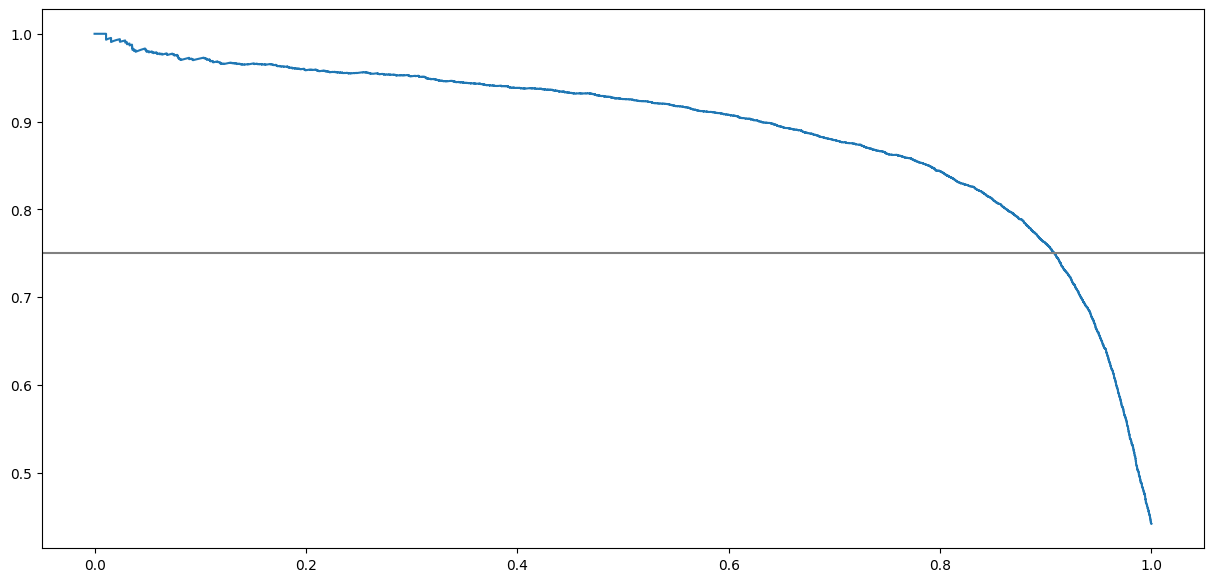

In [104]:
precision, recall, thrs = precision_recall_curve(global_y_test["target"], global_X_test["scores"])
pr_auc = auc(recall, precision)

fig, ax1 = plt.subplots(1, figsize=(15, 7))

ax1.plot(recall, precision)
ax1.axhline(y=0.75, color='grey', linestyle='-');

In [56]:
%%time

log_log_loss = []
log_auc = []
cats_models = {}
for group_cat in tqdm(fix_cat3_for_model):
# for group_cat in ["Компьютер"]:
    print(f"group_cat: {group_cat}")
    model_by_cat = ModelByCat()
    sub_train = train_features[train_features["cat3_grouped_model"]==group_cat]
    
    model_by_cat.create_train_test_by_cat(train_features=sub_train, feats=feats, cat_features=cat_features)
    model_by_cat.fit_model(plot=False, verbose=False)
    model_by_cat.predict()
    
    log_log_loss.append(model_by_cat.log_loss)
    log_auc.append(model_by_cat.auc_score)
    
    cats_models[group_cat] = model_by_cat
    print(f"logloss: {model_by_cat.log_loss}")
    print(f"auc_score: {model_by_cat.auc_score}")
    print()

print(f"mean log_loss: {np.mean(log_log_loss)}")
print(f"mean log_auc: {np.mean(log_auc)}")  


  0%|          | 0/30 [00:00<?, ?it/s]

group_cat: Видеонаблюдение
class_weights: {0.0: 1.4037925264919129, 1.0: 0.7766121567417463}
before: 1.0    3241
0.0    1793
Name: target, dtype: int64
src_prc_weight: 0.5532243134834928
count_part_undering: 0.5979018821351435
after RandomOverSampler: 1.0    3241
0.0    1937
Name: target, dtype: int64
model_bbc 0.7233333333333334
model_cat 0.7094444444444445
model_lgbm 0.6919444444444445
first model score_auc: 0.7985347222222222
first model score_auc: 0.5406913939250824


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


logloss: 0.5406913939250824
auc_score: 0.7985347222222222

group_cat: Запчасти для смартфонов
class_weights: {0.0: 1.204096742349457, 1.0: 0.8550648440238345}
before: 1.0    2853
0.0    2026
Name: target, dtype: int64
src_prc_weight: 0.7101296880476691
count_part_undering: 0.7391167192429021
after RandomOverSampler: 1.0    2853
0.0    2108
Name: target, dtype: int64
model_bbc 0.7404176321152397
model_cat 0.7697509840596298
model_lgbm 0.7545922782725218
first model score_auc: 0.807180145724575
first model score_auc: 0.6012420222771822
logloss: 0.6012420222771822
auc_score: 0.807180145724575

group_cat: Устройство ручного ввода


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


class_weights: {0.0: 1.414684167350287, 1.0: 0.7733183856502243}
before: 1.0    4460
0.0    2438
Name: target, dtype: int64
src_prc_weight: 0.5466367713004484
count_part_undering: 0.5919730941704036
after RandomOverSampler: 1.0    4460
0.0    2640
Name: target, dtype: int64
model_bbc 0.7809412569932151
model_cat 0.7578673669801215
model_lgbm 0.7516478693012736
first model score_auc: 0.8488349601237948
first model score_auc: 0.48045465373301943


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


logloss: 0.48045465373301943
auc_score: 0.8488349601237948

group_cat: Запчасти для ноутбуков
class_weights: {0.0: 0.7572608200455581, 1.0: 1.471776425013835}
before: 0.0    3512
1.0    1807
Name: target, dtype: int64
src_prc_weight: 0.5145216400911162
count_part_undering: 0.5630694760820046
after RandomOverSampler: 0.0    3512
1.0    1977
Name: target, dtype: int64
model_bbc 0.7491443040551717
model_cat 0.7550991843849805
model_lgbm 0.76007430876309
first model score_auc: 0.8426601010293799
first model score_auc: 0.47797358610052804
logloss: 0.47797358610052804
auc_score: 0.8426601010293799

group_cat: Защитные пленки и стекла


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


class_weights: {0.0: 0.5987012987012987, 1.0: 3.0328947368421053}
before: 0.0    3465
1.0     684
Name: target, dtype: int64
src_prc_weight: 0.1974025974025974
count_part_undering: 0.27766233766233767
after RandomOverSampler: 0.0    3465
1.0     962
Name: target, dtype: int64
model_bbc 0.6543496045814017
model_cat 0.6372716116716662
model_lgbm 0.6320902645214072
first model score_auc: 0.7014419143714208
first model score_auc: 0.5611895588078847
logloss: 0.5611895588078847
auc_score: 0.7014419143714208

group_cat: Наушники и гарнитуры


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


class_weights: {0.0: 3.3267684887459805, 1.0: 0.5884402104365136}
before: 1.0    7033
0.0    1244
Name: target, dtype: int64
src_prc_weight: 0.17688042087302716
count_part_undering: 0.25919237878572443
after RandomOverSampler: 1.0    7033
0.0    1822
Name: target, dtype: int64
model_bbc 0.7670502983802217
model_cat 0.7065217391304348
model_lgbm 0.6967178175618074
first model score_auc: 0.8134845620667926
first model score_auc: 0.5044076315059515


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


logloss: 0.5044076315059515
auc_score: 0.8134845620667926

group_cat: Акустика и колонки
class_weights: {0.0: 4.2439024390243905, 1.0: 0.5667752442996743}
before: 1.0    2149
0.0     287
Name: target, dtype: int64
src_prc_weight: 0.13355048859934854
count_part_undering: 0.2201954397394137
after RandomOverSampler: 1.0    2149
0.0     473
Name: target, dtype: int64
model_bbc 0.7411087866108786
model_cat 0.7176385983263598
model_lgbm 0.7207112970711297
first model score_auc: 0.8369508368200836
first model score_auc: 0.5523880267333546
logloss: 0.5523880267333546
auc_score: 0.8369508368200836

group_cat: rest


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


class_weights: {0.0: 1.5498531331592689, 1.0: 0.7381285458925935}
before: 1.0    12867
0.0     6128
Name: target, dtype: int64
src_prc_weight: 0.47625709178518694
count_part_undering: 0.5286313826066682
after RandomOverSampler: 1.0    12867
0.0     6801
Name: target, dtype: int64
model_bbc 0.8060220983128472
model_cat 0.789557212244437
model_lgbm 0.7834385878438741


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


first model score_auc: 0.8767284844377357
first model score_auc: 0.4361074276373056


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


logloss: 0.4361074276373056
auc_score: 0.8767284844377357

group_cat: Принтеры и МФУ
class_weights: {0.0: 1.813976377952756, 1.0: 0.6902621722846441}
before: 1.0    1335
0.0     508
Name: target, dtype: int64
src_prc_weight: 0.3805243445692884
count_part_undering: 0.4424719101123596
after RandomOverSampler: 1.0    1335
0.0     590
Name: target, dtype: int64
model_bbc 0.7027804410354745
model_cat 0.623741610738255
model_lgbm 0.6281759348034516
first model score_auc: 0.7498801534036433
first model score_auc: 0.5648173594444458
logloss: 0.5648173594444458
auc_score: 0.7498801534036433

group_cat: Жесткие диски, SSD и сетевые накопители


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


class_weights: {0.0: 0.7974537037037037, 1.0: 1.3404669260700388}
before: 0.0    3456
1.0    2056
Name: target, dtype: int64
src_prc_weight: 0.5949074074074074
count_part_undering: 0.6354166666666667
after RandomOverSampler: 0.0    3456
1.0    2196
Name: target, dtype: int64
model_bbc 0.9030260644104804
model_cat 0.8889647016011646
model_lgbm 0.8789289938136826
first model score_auc: 0.9479450964337699
first model score_auc: 0.29332896511805495
logloss: 0.29332896511805495
auc_score: 0.9479450964337699

group_cat: Батарейки и аккумуляторы


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


class_weights: {0.0: 1.0418346774193548, 1.0: 0.9613953488372093}
before: 1.0    3225
0.0    2976
Name: target, dtype: int64
src_prc_weight: 0.9227906976744186
count_part_undering: 0.9305116279069767
model_bbc 0.8372251008455839
model_cat 0.8586305254097116
model_lgbm 0.843752637175311
first model score_auc: 0.8805422876335465
first model score_auc: 0.5138887917688585
logloss: 0.5138887917688585
auc_score: 0.8805422876335465

group_cat: Компьютер


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


class_weights: {0.0: 0.5668135336862525, 1.0: 4.24175688976378}
before: 0.0    30413
1.0     4064
Name: target, dtype: int64
src_prc_weight: 0.13362706737250518
count_part_undering: 0.22026436063525467
after RandomOverSampler: 0.0    30413
1.0     6698
Name: target, dtype: int64
model_bbc 0.7592941305879364
model_cat 0.6685350957370747
model_lgbm 0.6745027852928158


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


first model score_auc: 0.8020978741681443
first model score_auc: 0.48703319157878466


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


logloss: 0.48703319157878466
auc_score: 0.8020978741681443

group_cat: Расходник для печати
class_weights: {0.0: 0.9008780487804878, 1.0: 1.1236310537843757}
before: 0.0    10250
1.0     8218
Name: target, dtype: int64
src_prc_weight: 0.8017560975609757
count_part_undering: 0.8215804878048781
after RandomOverSampler: 0.0    10250
1.0     8421
Name: target, dtype: int64
model_bbc 0.847181526809609
model_cat 0.862319899760267
model_lgbm 0.8568434485006833


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


first model score_auc: 0.9045231929393687
first model score_auc: 0.4216743092719181


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


logloss: 0.4216743092719181
auc_score: 0.9045231929393687

group_cat: Аксессуары для фото и видеотехники
class_weights: {0.0: 0.8189858490566038, 1.0: 1.2837338262476894}
before: 0.0    848
1.0    541
Name: target, dtype: int64
src_prc_weight: 0.6379716981132075
count_part_undering: 0.6741745283018867
after RandomOverSampler: 0.0    848
1.0    571
Name: target, dtype: int64
model_bbc 0.9039473684210527
model_cat 0.9039473684210527
model_lgbm 0.8925438596491229
first model score_auc: 0.9554385964912281
first model score_auc: 0.26239158160977544


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


logloss: 0.26239158160977544
auc_score: 0.9554385964912281

group_cat: Кабели и переходники
class_weights: {0.0: 0.683015363835894, 1.0: 1.8660055350553506}
before: 0.0    11846
1.0     4336
Name: target, dtype: int64
src_prc_weight: 0.36603072767178796
count_part_undering: 0.42942765490460916
after RandomOverSampler: 0.0    11846
1.0     5087
Name: target, dtype: int64
model_bbc 0.8576853278386375
model_cat 0.8494992076169592
model_lgbm 0.8476757814346071


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


first model score_auc: 0.9103394171967599
first model score_auc: 0.3494443839934969


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


logloss: 0.3494443839934969
auc_score: 0.9103394171967599

group_cat: Смарт-часы
class_weights: {0.0: 1.7924328147100423, 1.0: 0.6934336525307797}
before: 1.0    7310
0.0    2828
Name: target, dtype: int64
src_prc_weight: 0.38686730506155953
count_part_undering: 0.4481805745554036
after RandomOverSampler: 1.0    7310
0.0    3276
Name: target, dtype: int64
model_bbc 0.7508304541644142
model_cat 0.7151973112087808
model_lgbm 0.7182723419590884


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


first model score_auc: 0.8149849969837277
first model score_auc: 0.4995584100453037


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


logloss: 0.4995584100453037
auc_score: 0.8149849969837277

group_cat: Видеокарты и графические ускорители
class_weights: {0.0: 1.2865921787709498, 1.0: 0.8178267045454546}
before: 1.0    1408
0.0     895
Name: target, dtype: int64
src_prc_weight: 0.6356534090909091
count_part_undering: 0.6720880681818182
after RandomOverSampler: 1.0    1408
0.0     946
Name: target, dtype: int64
model_bbc 0.6878205128205128
model_cat 0.6826923076923077
model_lgbm 0.6624358974358974


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


first model score_auc: 0.7697115384615385
first model score_auc: 0.5530574840818574
logloss: 0.5530574840818574
auc_score: 0.7697115384615385

group_cat: Карты памяти и флешки
class_weights: {0.0: 0.73681640625, 1.0: 1.5556701030927835}
before: 0.0    2048
1.0     970
Name: target, dtype: int64
src_prc_weight: 0.4736328125
count_part_undering: 0.52626953125
after RandomOverSampler: 0.0    2048
1.0    1077
Name: target, dtype: int64
model_bbc 0.8425925925925926
model_cat 0.8411306042884991
model_lgbm 0.8155458089668616
first model score_auc: 0.8928484405458089
first model score_auc: 0.4041029012383889
logloss: 0.4041029012383889
auc_score: 0.8928484405458089

group_cat: Оперативная память


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


class_weights: {0.0: 0.6211940298507462, 1.0: 2.562807881773399}
before: 0.0    1675
1.0     406
Name: target, dtype: int64
src_prc_weight: 0.24238805970149255
count_part_undering: 0.3181492537313433
after RandomOverSampler: 0.0    1675
1.0     532
Name: target, dtype: int64
model_bbc 0.855377302436126
model_cat 0.8119429590017825
model_lgbm 0.8177064765300059


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


first model score_auc: 0.8939988116458705
first model score_auc: 0.3539684470092024
logloss: 0.3539684470092024
auc_score: 0.8939988116458705

group_cat: Сетевые фильтры, разветвители и удлинители
class_weights: {0.0: 0.8226795096322241, 1.0: 1.2747625508819538}
before: 0.0    1142
1.0     737
Name: target, dtype: int64
src_prc_weight: 0.6453590192644484
count_part_undering: 0.6808231173380035
after RandomOverSampler: 0.0    1142
1.0     777
Name: target, dtype: int64
model_bbc 0.8599001344344152
model_cat 0.8652294987516804
model_lgbm 0.8731035144997119
first model score_auc: 0.9102170155559823
first model score_auc: 0.37742085569496386


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


logloss: 0.37742085569496386
auc_score: 0.9102170155559823

group_cat: Мониторы и запчасти
class_weights: {0.0: 1.0880208333333334, 1.0: 0.9251550044286979}
before: 1.0    1129
0.0     960
Name: target, dtype: int64
src_prc_weight: 0.8503100088573959
count_part_undering: 0.8652790079716564
after RandomOverSampler: 1.0    1129
0.0     976
Name: target, dtype: int64
model_bbc 0.6646639964396974
model_cat 0.6784230826286901
model_lgbm 0.6478267319388814
first model score_auc: 0.714804925085299
first model score_auc: 0.7807249635063381
logloss: 0.7807249635063381
auc_score: 0.714804925085299

group_cat: Смартфоны, планшеты, мобильные телефоны


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


class_weights: {0.0: 0.7895663708718325, 1.0: 1.3633599241766052}
before: 0.0    21862
1.0    12661
Name: target, dtype: int64
src_prc_weight: 0.5791327417436648
count_part_undering: 0.6212194675692984
after RandomOverSampler: 0.0    21862
1.0    13581
Name: target, dtype: int64
model_bbc 0.8236739317000833
model_cat 0.8333220681278662
model_lgbm 0.8300285316931194


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


first model score_auc: 0.8947136340879851
first model score_auc: 0.4219189929839863


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


logloss: 0.4219189929839863
auc_score: 0.8947136340879851

group_cat: Зарядные устройства и док-станции
class_weights: {0.0: 1.1400313356835097, 1.0: 0.8906058751529988}
before: 1.0    3268
0.0    2553
Name: target, dtype: int64
src_prc_weight: 0.7812117503059975
count_part_undering: 0.8030905752753978
after RandomOverSampler: 1.0    3268
0.0    2624
Name: target, dtype: int64
model_bbc 0.6974498506188647
model_cat 0.7188676133938618
model_lgbm 0.6914746052069995
first model score_auc: 0.7666550265782018
first model score_auc: 0.6333180898377647
logloss: 0.6333180898377647
auc_score: 0.7666550265782018



D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


group_cat: Чехол
class_weights: {0.0: 0.654258653109548, 1.0: 2.1206546275395035}
before: 0.0    14359
1.0     4430
Name: target, dtype: int64
src_prc_weight: 0.308517306219096
count_part_undering: 0.3776655755971864
after RandomOverSampler: 0.0    14359
1.0     5422
Name: target, dtype: int64
model_bbc 0.8052066140962162
model_cat 0.7911470750045846
model_lgbm 0.7825432483648145


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


first model score_auc: 0.8740945351182835
first model score_auc: 0.40395323802755856


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


logloss: 0.40395323802755856
auc_score: 0.8740945351182835

group_cat: Материнская плата
class_weights: {0.0: 0.7786226685796269, 1.0: 1.3972708547888775}
before: 0.0    3485
1.0    1942
Name: target, dtype: int64
src_prc_weight: 0.557245337159254
count_part_undering: 0.6015208034433286
after RandomOverSampler: 0.0    3485
1.0    2096
Name: target, dtype: int64
model_bbc 0.7982342807924203
model_cat 0.7808462532299743
model_lgbm 0.7828919035314384
first model score_auc: 0.8703584075031104
first model score_auc: 0.4882805338433652
logloss: 0.4882805338433652
auc_score: 0.8703584075031104

group_cat: Электронные модули


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


class_weights: {0.0: 0.6125827814569537, 1.0: 2.7205882352941178}
before: 0.0    2265
1.0     510
Name: target, dtype: int64
src_prc_weight: 0.2251655629139073
count_part_undering: 0.3026490066225166
after RandomOverSampler: 0.0    2265
1.0     685
Name: target, dtype: int64
model_bbc 0.7675438596491229
model_cat 0.6847326649958227
model_lgbm 0.6779448621553884
first model score_auc: 0.8354566972988026
first model score_auc: 0.47985782645715763
logloss: 0.47985782645715763
auc_score: 0.8354566972988026

group_cat: Телевизоры


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


class_weights: {0.0: 0.8126470588235294, 1.0: 1.299623706491063}
before: 0.0    1700
1.0    1063
Name: target, dtype: int64
src_prc_weight: 0.6252941176470588
count_part_undering: 0.6627647058823529
after RandomOverSampler: 0.0    1700
1.0    1126
Name: target, dtype: int64
model_bbc 0.7809099018733274
model_cat 0.769536128456735
model_lgbm 0.7616413916146296
first model score_auc: 0.860414808206958
first model score_auc: 0.5619534287086636
logloss: 0.5619534287086636
auc_score: 0.860414808206958

group_cat: Игровая приставка


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


class_weights: {0.0: 15.336065573770492, 1.0: 0.5168508287292818}
before: 1.0    10860
0.0      366
Name: target, dtype: int64
src_prc_weight: 0.03370165745856354
count_part_undering: 0.1303314917127072
after RandomOverSampler: 1.0    10860
0.0     1415
Name: target, dtype: int64
model_bbc 0.6343888293895367
model_cat 0.5694424798431911
model_lgbm 0.5589043587204721


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


first model score_auc: 0.7091357326166468
first model score_auc: 0.556094222889545


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


logloss: 0.556094222889545
auc_score: 0.7091357326166468

group_cat: Оптические приборы
class_weights: {0.0: 1.501974333662389, 1.0: 0.7495073891625615}
before: 1.0    2030
0.0    1013
Name: target, dtype: int64
src_prc_weight: 0.49901477832512314
count_part_undering: 0.5491133004926109
after RandomOverSampler: 1.0    2030
0.0    1114
Name: target, dtype: int64
model_bbc 0.8473451327433629
model_cat 0.8407079646017698
model_lgbm 0.838495575221239
first model score_auc: 0.907471219359386
first model score_auc: 0.4073912805608634
logloss: 0.4073912805608634
auc_score: 0.907471219359386

group_cat: Сетевое оборудование


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


class_weights: {0.0: 2.0103092783505154, 1.0: 0.6655290102389079}
before: 1.0    1758
0.0     582
Name: target, dtype: int64
src_prc_weight: 0.3310580204778157
count_part_undering: 0.39795221843003414
after RandomOverSampler: 1.0    1758
0.0     699
Name: target, dtype: int64
model_bbc 0.7435897435897435
model_cat 0.7205128205128205
model_lgbm 0.7282051282051281
first model score_auc: 0.8210650887573964
first model score_auc: 0.47940336916493637
logloss: 0.47940336916493637
auc_score: 0.8210650887573964

mean log_loss: 0.4816012309185179
mean log_auc: 0.8404171074289156
Wall time: 24min 22s


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [57]:
global_y_test = pd.DataFrame()
global_X_test = global_y_test
for group_cat in fix_cat3_for_model:
# for group_cat in ["Защитные пленки и стекла", "Компьютер", "Запчасти для ноутбуков"]:
# for group_cat in ["Компьютер", "Компьютер.Системный блок","Компьютер.Ноутбук" ]:
# for group_cat in ["Компьютер"]:
    global_y_test = pd.concat((global_y_test, cats_models[group_cat].y_test))
    global_X_test = pd.concat((global_X_test, cats_models[group_cat].X_test))
global_y_test.shape, global_X_test.shape

pr_auc_macro_metr = pr_auc_macro(
    target_df=global_y_test, 
    predictions_df=global_X_test,
    prec_level=0.75,
    cat_column="cat3_grouped_model"    
#     cat_column="cat3_grouped"
)

pr_auc_macro_metr

,cat_name,weight,score,counts
10,Защитные пленки и стекла,0.016729,0.158904,513
14,Компьютер,0.138823,0.177369,4257
7,Запчасти для ноутбуков,0.021425,0.425607,657
9,Зарядные устройства и док-станции,0.023447,0.476722,719
26,Телевизоры,0.011153,0.548023,342
16,Мониторы и запчасти,0.008414,0.557016,258
29,Электронные модули,0.011185,0.575579,343
18,Оперативная память,0.008381,0.583370,257
28,Чехол,0.075656,0.585815,2320
13,Карты памяти и флешки,0.012164,0.620175,373


0.6826809358611533

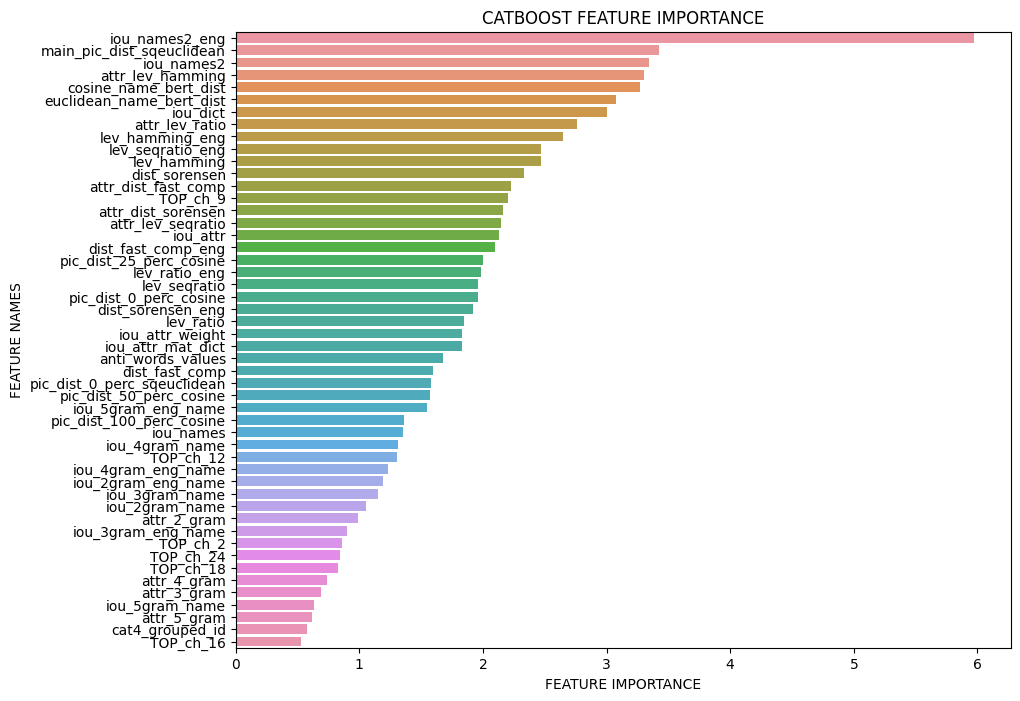

In [58]:
plot_feature_importance(cats_models["Компьютер"].model_cat.get_feature_importance(), (feats + cat_features),'CATBOOST ', top_n=50)

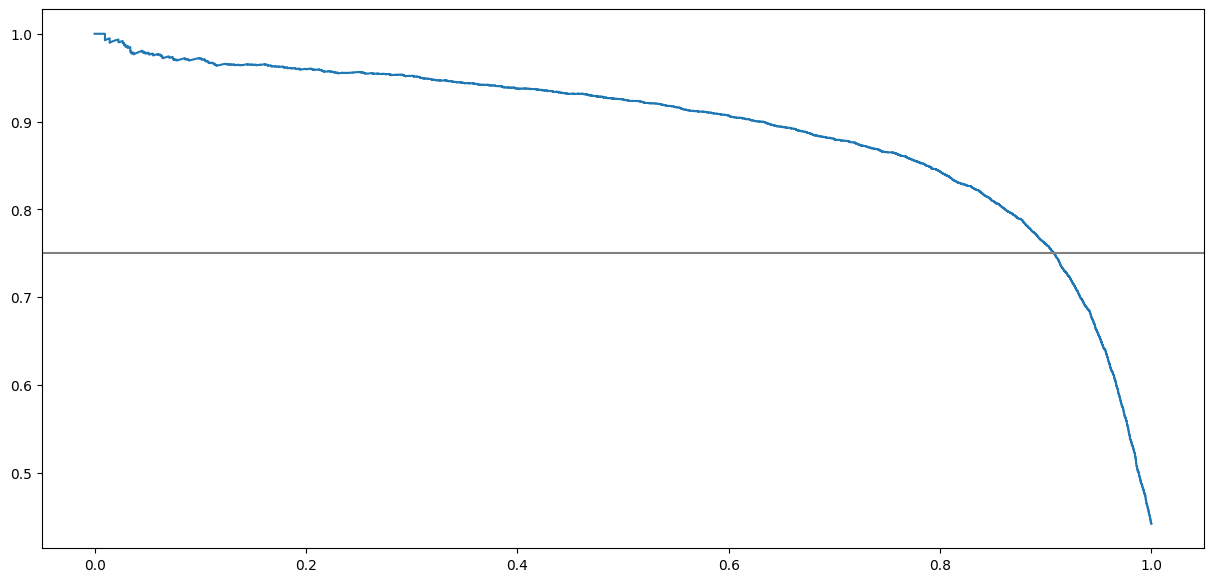

In [59]:
precision, recall, thrs = precision_recall_curve(global_y_test["target"], global_X_test["scores"])
pr_auc = auc(recall, precision)

fig, ax1 = plt.subplots(1, figsize=(15, 7))

ax1.plot(recall, precision)
ax1.axhline(y=0.75, color='grey', linestyle='-');

# Submission

In [134]:
test_pairs = pd.read_parquet(PATH + "test_pairs_wo_target.parquet")
test_etl = pd.read_parquet(PATH + "test_data.parquet")


In [135]:
test_features = (
    test_pairs
    .merge(
        test_etl
        .add_suffix('1'),
        on="variantid1"
    )
    .merge(
        test_etl
        .add_suffix('2'),
        on="variantid2"
    )
)

In [136]:
%%time
# Сравнение схожести эмбеддингов дополнительных картинок берется несколько перценталей
for metric in ["cosine"]:
    test_features[[f"pic_dist_0_perc_{metric}", f"pic_dist_25_perc_{metric}", f"pic_dist_50_perc_{metric}", f"pic_dist_100_perc_{metric}"]] = (
        test_features[["pic_embeddings_resnet_v11", "pic_embeddings_resnet_v12"]].apply(
            lambda x: pd.Series(get_pic_features_func(*x, metric=metric)), axis=1
        )
    )

# Сравнение схожести эмбеддингов дополнительных картинок берется миниальное расстоние среди пар сравнения 
test_features[f"pic_dist_0_perc_sqeuclidean"] = (
    test_features[["pic_embeddings_resnet_v11", "pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_func(*x, percentiles=[0], metric="sqeuclidean")), axis=1
    )
)


# Сравнение схожести эмбеддингов главных картинок
test_features[f"main_pic_dist_sqeuclidean"] = (
    test_features[["main_pic_embeddings_resnet_v11", "main_pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_func(*x, percentiles=[0], metric="sqeuclidean")), axis=1
    )
)

Wall time: 24.3 s


In [137]:
test_features[["euclidean_name_bert_dist", "cosine_name_bert_dist"]] = (
    test_features[["name_bert_641", "name_bert_642"]].apply(
        lambda x: pd.Series(text_dense_distances(*x)), axis=1
    )
)

In [138]:
#### Сравнение текстового описания
test_features["iou_names"] = test_features.apply(lambda x: text_title_iou(x["name1"], x["name2"]), axis=1)
test_features["iou_names2"] = test_features.apply(lambda x: text_title_iou_filter(x["name1"], x["name2"]), axis=1)
test_features["iou_names2_eng"] = test_features.apply(lambda x: text_title_iou_filter(x["name1"], x["name2"], skip_rus=True), axis=1)

In [139]:
%%time
#### Сравнение n-gram описания
test_features["iou_2gram_name"] = test_features.apply(lambda x: calc_iou_ngram(x["name1"], x["name2"], 2), axis=1)
test_features["iou_3gram_name"] = test_features.apply(lambda x: calc_iou_ngram(x["name1"], x["name2"], 3), axis=1)
test_features["iou_4gram_name"] = test_features.apply(lambda x: calc_iou_ngram(x["name1"], x["name2"], 4), axis=1)
test_features["iou_5gram_name"] = test_features.apply(lambda x: calc_iou_ngram(x["name1"], x["name2"], 5), axis=1)

test_features["iou_2gram_eng_name"] = test_features.apply(lambda x: calc_iou_ngram(x["name1"], x["name2"], 2, skip_rus=True), axis=1)
test_features["iou_3gram_eng_name"] = test_features.apply(lambda x: calc_iou_ngram(x["name1"], x["name2"], 3, skip_rus=True), axis=1)
test_features["iou_4gram_eng_name"] = test_features.apply(lambda x: calc_iou_ngram(x["name1"], x["name2"], 4, skip_rus=True), axis=1)
test_features["iou_5gram_eng_name"] = test_features.apply(lambda x: calc_iou_ngram(x["name1"], x["name2"], 5, skip_rus=True), axis=1)


Wall time: 7.37 s


In [140]:
%%time
# Поиск слов влияющих на отличие товаров
test_features["anti_words_values"] = test_features.apply(lambda x: calc_anti_words_values(x["name1"], x["name2"]), axis=1 )

Wall time: 485 ms


In [141]:
%%time
# Кодирование цветов
test_features[colors_columns_name_1] = test_features["color_parsed1"].apply(lambda x:  pd.Series(get_codes_by_colors(x)))
test_features[colors_columns_name_2] = test_features["color_parsed2"].apply(lambda x:  pd.Series(get_codes_by_colors(x)))
test_features[["color_dist_euclidean", "color_sim_cosine", "iou_color"] + colors_columns_name] = test_features.apply(lambda x: pd.Series(color_dist(x["color_parsed1"], x["color_parsed2"])), axis=1)

D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\scipy\spatial\distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Wall time: 10.5 s


In [142]:
%%time
# Рассчет метрики схожести характеристик товаров
test_features[["iou_attr", "iou_attr_weight", "iou_dict", "iou_attr_mat_dict"]] = test_features[["characteristic_attributes_mapping1","characteristic_attributes_mapping2"]].apply(lambda x: pd.Series(split_attributes(*x)), axis=1)

Wall time: 5.92 s


In [143]:
# Признак совпадения категорий
test_features[["cat_level_1_1", "cat_level_2_1", "cat_level_3_1", "cat_level_4_1"]] = test_features["categories1"].apply(lambda x: pd.Series(split_cat_product(x)))
test_features[["cat_level_1_2", "cat_level_2_2", "cat_level_3_2", "cat_level_4_2"]] = test_features["categories2"].apply(lambda x: pd.Series(split_cat_product(x)))

test_features["is_equal_cat_2"] = test_features.apply(lambda x: 1 if x["cat_level_2_1"] == x["cat_level_2_2"] else 0, axis=1)
test_features["is_equal_cat_3"] = test_features.apply(lambda x: 1 if x["cat_level_3_1"] == x["cat_level_3_2"] else 0, axis=1)
test_features["is_equal_cat_4"] = test_features.apply(lambda x: 1 if x["cat_level_4_1"] == x["cat_level_4_2"] else 0, axis=1)


In [144]:
%%time
# Применим такие же словари как и в трейне
test_features["cat3_grouped"] = test_features["cat_level_3_1"].apply(lambda x: x if x in fix_cat3 else "rest")
test_features["cat3_grouped_id"] = test_features["cat3_grouped"].apply(lambda x: fix_cat3.index(x))
test_features["cat3_grouped_model"] = test_features["cat_level_3_1"].apply(lambda x: x if x in fix_cat3_for_model else "rest")
test_features["cat4_grouped"] = test_features["cat_level_4_1"].apply(lambda x: x if x in fix_cat4 else "rest")
test_features["cat4_grouped_id"] = test_features["cat4_grouped"].apply(lambda x: fix_cat4.index(x))

Wall time: 99 ms


In [145]:
%%time
# ТОП N Характеристик товаров
# test_features[[f"TOP_ch_{i+1}" for i in range(TOP_N_characts)]] = test_features.apply(lambda x: pd.Series(code_top_characteristics(x["characteristic_attributes_mapping1"], x["characteristic_attributes_mapping2"], x["cat_level_3_1"],x["cat_level_3_2"])), axis=1)
# test_features[top_chars_columns] = test_features.apply(lambda x: pd.Series(code_top_df_idf_characteristics(x["characteristic_attributes_mapping1"], x["characteristic_attributes_mapping2"], x["cat3_grouped_model"], x["cat_level_3_1"],x["cat_level_3_2"])), axis=1)
# test_features[top_chars_columns + ["attr_2_gram", "attr_3_gram", "attr_4_gram", "attr_5_gram"]] = test_features.apply(lambda x: pd.Series(code_top_df_idf_characteristics(x["characteristic_attributes_mapping1"], x["characteristic_attributes_mapping2"], x["cat3_grouped_model"], x["cat_level_3_1"],x["cat_level_3_2"])), axis=1)
test_features[top_chars_columns + ["attr_2_gram", "attr_3_gram", "attr_4_gram", "attr_5_gram"] + columns_attr_distance] = test_features.apply(lambda x: pd.Series(code_top_df_idf_characteristics(x["characteristic_attributes_mapping1"], x["characteristic_attributes_mapping2"], x["cat3_grouped_model"], x["cat_level_3_1"],x["cat_level_3_2"])), axis=1)


Wall time: 17.7 s


In [146]:
%%time
test_features[columns_text_distance] = test_features.apply(lambda x: pd.Series(calc_additional_distance(x["name1"], x["name2"])), axis=1 )
test_features[columns_text_distance_eng] = test_features.apply(lambda x: pd.Series(calc_additional_distance(x["name1"], x["name2"], skip_rus=True)), axis=1 )

Wall time: 8.9 s


In [147]:
submission_example = test_features.copy()

In [148]:
# def temp_predict_proba(self, X_test):
#     predict_model_bbc = self.model_bbc.predict_proba(X_test)[:, 1]
#     predict_model_cat = self.model_cat.predict_proba(X_test)[:, 1]
#     predict_model_lgbm = self.model_lgbm.predict_proba(X_test)[:, 1]
#     mean_predict = np.mean((
#         predict_model_bbc  * 1.0,
#         predict_model_cat * 1.0,
#         predict_model_lgbm * 1.0,
#         ), axis=0)        
#     return mean_predict
# submission_example["target"] = test_features.apply(lambda x: temp_predict_probacats_models[x["cat3_grouped_model"]].voting_model.predict_proba(x[feats+cat_features])[1], axis=1)

In [149]:
# # cats_models[x["cat3_grouped_model"]].predict_proba(x[feats+cat_features].to_numpy()[None])
# xxxx = test_features.iloc[0][feats+cat_features].to_numpy()
# cats_models["Компьютер"].predict_proba(xxxx[None])
# submission_example["target"] = test_features[test_features["cat3_grouped_model"] == "Материнская плата"].apply(lambda x: cats_models[x["cat3_grouped_model"]].predict_proba(x[feats+cat_features].to_numpy()[None])[0], axis=1)

In [157]:
%%time
submission_example["target"] = test_features.apply(lambda x: cats_models[x["cat3_grouped_model"]].predict_proba(x[feats+cat_features].to_numpy()[None])[0], axis=1)
# submission_example["target"] = test_features.apply(lambda x: cats_models[x["cat3_grouped_model"]].predict_proba(x[feats+cat_features].to_numpy()[None])[1], axis=1)

Wall time: 8min 16s


In [158]:
submission_example = submission_example[["variantid1", "variantid2", "target"]]

In [159]:
# ФОРМАТ variantid1,variantid2,scores
import time
# время для указания в названии файла submission
timestr = time.strftime("%d-%H_%M")

submission_example.drop_duplicates().merge(
    test_features[["variantid1", "variantid2"]].drop_duplicates(["variantid1", "variantid2"]),
    on=["variantid1", "variantid2"]
).to_csv(PATH_SUBMISSION + f"{timestr}_submission_score.csv", index=False)

#### Поиск кластеров

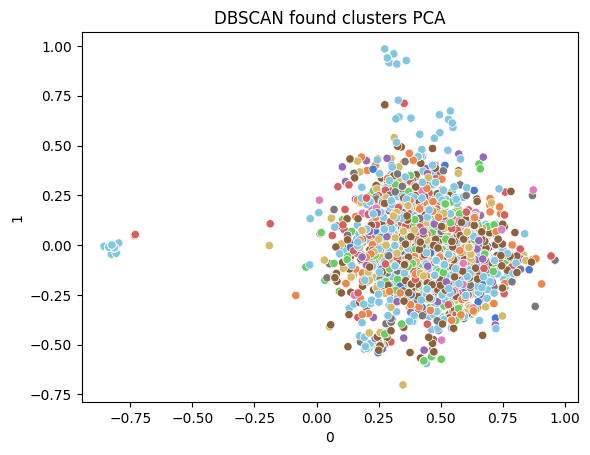

In [1173]:
# from sklearn.cluster import DBSCAN
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# import seaborn as sns

# sample = train_features[train_features["cat4_grouped_id"]!=0][:5000]
# dbs = DBSCAN(eps=0.005)

# pca = PCA(n_components=2)
# # z = pca.fit_transform(np.array([i[0] for i in sample["main_pic_embeddings_resnet_v12"]]))
# z = pca.fit_transform(np.array([i for i in sample["name_bert_642"]]))
# df_dbscan = pd.DataFrame(z)
# df_dbscan["label"] = sample["cat4_grouped_id"]
# sns.scatterplot(data=df_dbscan, hue='label', palette='muted', x=0, y=1).set_title('DBSCAN found clusters PCA');
# plt.legend([],[], frameon=False)
# plt.show()

D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


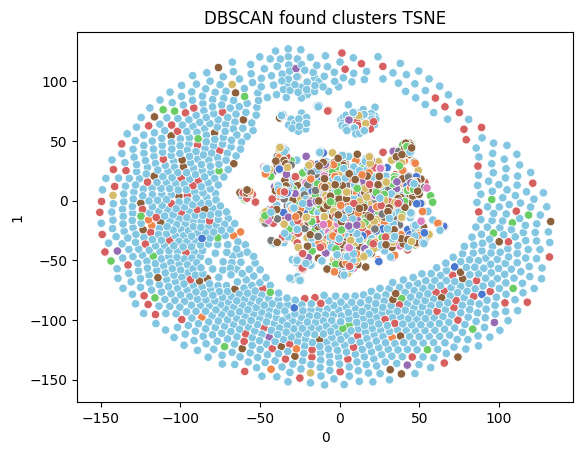

In [1174]:
# tsne_z = TSNE(n_components=2).fit_transform(np.array([i for i in sample["name_bert_642"]]))
# df_dbscan = pd.DataFrame(tsne_z)
# df_dbscan["label"] = sample["cat4_grouped_id"]
# sns.scatterplot(data=df_dbscan, x=0, y=1, hue='label', palette='muted').set_title('DBSCAN found clusters TSNE');
# plt.legend([],[], frameon=False)
# plt.show()

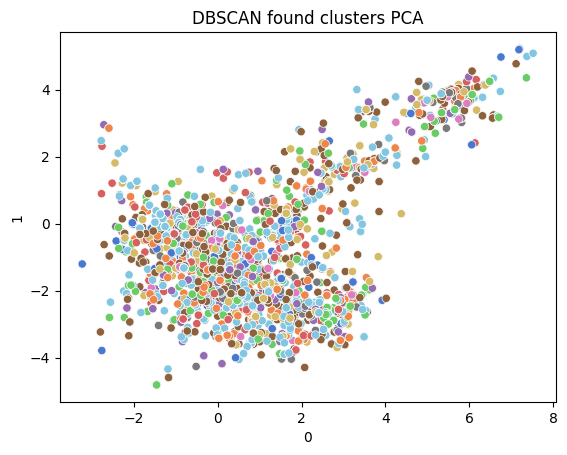

In [1178]:
# from sklearn.cluster import DBSCAN
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# import seaborn as sns

# sample = train_features[train_features["cat4_grouped_id"]!=0][:5000]
# dbs = DBSCAN(eps=0.005)

# pca = PCA(n_components=2)
# z = pca.fit_transform(np.array([i[0] for i in sample["main_pic_embeddings_resnet_v12"]]))
# # z = pca.fit_transform(np.array([i for i in sample["name_bert_64"]]))
# df_dbscan = pd.DataFrame(z)
# df_dbscan["label"] = sample["cat4_grouped_id"]
# sns.scatterplot(data=df_dbscan, hue='label', palette='muted', x=0, y=1).set_title('DBSCAN found clusters PCA');
# plt.legend([],[], frameon=False)
# plt.show()

D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


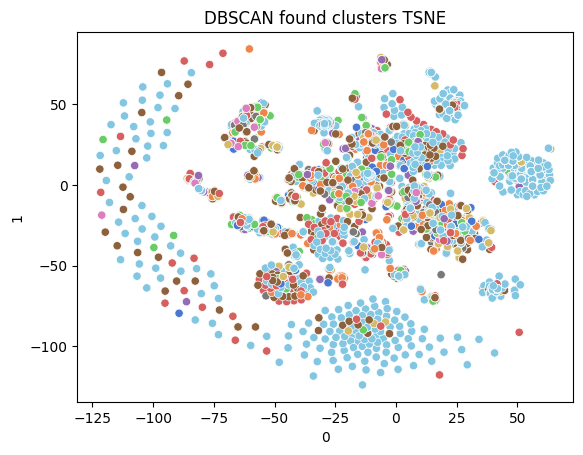

In [1175]:
# tsne_z = TSNE(n_components=2).fit_transform(np.array([i[0] for i in sample["main_pic_embeddings_resnet_v12"]]))
# df_dbscan = pd.DataFrame(tsne_z)
# df_dbscan["label"] = sample["cat4_grouped_id"]
# sns.scatterplot(data=df_dbscan, x=0, y=1, hue='label', palette='muted').set_title('DBSCAN found clusters TSNE');
# plt.legend([],[], frameon=False)
# plt.show()

Upload your submission to leaderboard :)

### Recommendations 

- Work with names, in electronics names often contain a lot of useful information for matching.
- Don't forget about attributes: working with it will allow your model to better distinguish matches from non-matches.